In [1]:
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 폰트 설정 방법 2
import matplotlib as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

#font_location = r'Fonts\H2HDRM.ttf' # For Windows
#font_name = fm.FontProperties(fname=font_location).get_name()
#plt.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error


### 추정매출 데이터 불러오기

In [2]:
rev_2020 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출).csv', encoding = 'cp949' )
rev_2019 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv', encoding = 'cp949' )
rev_2018 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2018.csv', encoding = 'cp949' )
rev_2017 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2017.csv', encoding = 'cp949' )
rev_2016 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2016.csv', encoding = 'cp949' )
rev_2015 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2015.csv', encoding = 'cp949' )

In [3]:
rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6415600,169,...,0,63,106,0,10,139,10,5,5,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,10400909742,5270,...,35,2458,2812,0,0,245,1441,1722,1862,5
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66506,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,257814129,27092,...,1205,10426,14742,234,4316,7089,6188,4351,2989,4
66507,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,156728306,3589,...,33,1281,2014,5,1361,1116,331,325,157,3
66508,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,55484866,1272,...,241,622,508,0,134,245,275,314,162,3
66509,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,25767161,1413,...,0,592,694,145,368,240,368,96,69,1


### 내가 관심있는 상권을 검색

In [4]:
mapo_rev_2020 = rev_2020.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2019 = rev_2019.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2018 = rev_2018.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2017 = rev_2017.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2016 = rev_2016.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2015 = rev_2015.groupby(['상권_코드']).get_group((1001182))

mapo_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
6798,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
6799,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300036,조명용품,142747635,4676,...,0,2339,669,0,337,1836,335,166,335,11
6800,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
6801,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
6802,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300031,가구,1212000000,1239,...,0,776,414,0,66,344,281,367,132,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40095,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,2817982864,291051,...,32849,89266,200021,12916,159322,58760,29543,23064,5681,67
40096,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,10575061772,403032,...,41801,151548,244118,13183,225110,86849,36033,28422,6066,208
40097,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,8332608324,313259,...,42878,155441,153156,10230,176438,65077,26408,24706,5739,143
40098,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,2154887595,95941,...,11182,42499,50276,4594,51097,17616,9537,8086,1843,62


### 년도와 상권코드를 입력하면 입력한 상권 및 연도의 4분기 동안 공통된 서비즈 업종을 찾는다

### ( 누락된 서비스 업종은 제외한다 )

In [5]:
def return_com_sc_by_year_and_ba(year,ba):
    if (year != 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,3,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,4,ba))['서비스_업종_코드_명'])
    
    if (year == 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])
    
    return common_sc

### 그리고나서 모든 연도와 비교하여 누락된 서비스 업종을 제외한다

In [6]:
common_sc_1001182 = set(return_com_sc_by_year_and_ba(2020,1001182)) &\
set(return_com_sc_by_year_and_ba(2019,1001182)) &\
set(return_com_sc_by_year_and_ba(2018,1001182)) &\
set(return_com_sc_by_year_and_ba(2017,1001182)) &\
set(return_com_sc_by_year_and_ba(2016,1001182)) &\
set(return_com_sc_by_year_and_ba(2015,1001182))

### 최종적으로 분석에 이용할 서비스 업종의 개수를 확인한다

In [7]:
len(common_sc_1001182)

44

### 위에서 구한 common_sc(공통 서비스 업종)으로 데이터를 필터링한다

In [8]:
# new_rev_2015~2020 에 대해서 공통 sc만 남기고 합침

mapo_new_rev_2020 = mapo_rev_2020.loc[mapo_rev_2020['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2019 = mapo_rev_2019.loc[mapo_rev_2019['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2018 = mapo_rev_2018.loc[mapo_rev_2018['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2017 = mapo_rev_2017.loc[mapo_rev_2017['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2016 = mapo_rev_2016.loc[mapo_rev_2016['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2015 = mapo_rev_2015.loc[mapo_rev_2015['서비스_업종_코드_명'].isin(common_sc_1001182)]

In [9]:
# print(gangnam_rev_2020.shape)
# print(gangnam_new_rev_2020.shape)
mapo_new_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
6798,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
6800,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
6801,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
6803,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300028,화초,777834762,29370,...,3165,13486,15359,421,13751,8786,3676,1648,565,33
6805,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300024,운동/경기용품,201416735,332,...,0,232,93,0,100,74,126,25,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40095,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,2817982864,291051,...,32849,89266,200021,12916,159322,58760,29543,23064,5681,67
40096,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,10575061772,403032,...,41801,151548,244118,13183,225110,86849,36033,28422,6066,208
40097,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,8332608324,313259,...,42878,155441,153156,10230,176438,65077,26408,24706,5739,143
40098,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,2154887595,95941,...,11182,42499,50276,4594,51097,17616,9537,8086,1843,62


### 필터링한 데이터를 합쳐서 하나의 큰 데이터로 만든다

In [10]:
mapo_all_rev = mapo_new_rev_2020.append(mapo_new_rev_2019, ignore_index=True)\
.append(mapo_new_rev_2018, ignore_index=True)\
.append(mapo_new_rev_2017, ignore_index=True)\
.append(mapo_new_rev_2016, ignore_index=True)\
.append(mapo_new_rev_2015, ignore_index=True)

mapo_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
1,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
2,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
3,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300028,화초,777834762,29370,...,3165,13486,15359,421,13751,8786,3676,1648,565,33
4,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300024,운동/경기용품,201416735,332,...,0,232,93,0,100,74,126,25,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,2015,4,D,발달상권,1001182,홍익대학교 주변,CS200028,미용실,10950069634,179482,...,9391,95489,82854,3744,80034,55705,22305,13330,3226,165
964,2015,4,D,발달상권,1001182,홍익대학교 주변,CS200016,당구장,266556478,19927,...,6479,15214,4643,1687,12353,2933,1670,1015,199,21
965,2015,4,D,발달상권,1001182,홍익대학교 주변,CS100006,패스트푸드점,4621384109,376994,...,59924,188933,170841,22938,217234,61416,32309,22405,3492,60
966,2015,4,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,5142497778,479400,...,43131,139728,322885,20630,235143,113636,54546,30532,8132,71


### 쓸모없는 열은 제외한다.

In [11]:
mapo_all_rev = mapo_all_rev.groupby(['서비스_업종_코드']).get_group(('CS100009'))
mapo_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
35,2020,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,15315944145,456620,...,161647,249107,203827,14883,294487,83245,29314,25277,5719,320
79,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,20675074684,635216,...,232371,348867,282650,26929,425855,102541,35121,33692,7368,335
114,2019,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,23287416756,702735,...,268998,379439,319307,45512,463732,105335,39264,38939,5962,357
156,2019,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,19121511785,582720,...,216231,314211,263467,30713,380070,95625,35222,30394,5642,339
180,2019,3,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,20612444009,634831,...,230622,345797,284084,33962,422611,95772,38789,32742,6005,325
250,2019,4,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,26001161885,801040,...,290050,439074,354999,41481,543120,120961,45540,36475,6493,314
279,2018,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,34945320804,1154300,...,499610,626817,513198,106244,788384,133263,56233,48363,7543,439
338,2018,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,33706562144,1093894,...,461772,591941,480813,84433,741513,136214,57892,45082,7649,414
394,2018,3,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,32998566150,1071660,...,450821,598492,454472,69629,747645,130511,52275,46063,6869,393
419,2018,4,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,47805836727,1422722,...,556166,797270,585689,81524,978690,179288,73581,58462,11461,375


In [12]:
mapo_all_rev = mapo_all_rev.drop(['상권_구분_코드','상권_구분_코드_명','상권_코드',
                                  '상권_코드_명','서비스_업종_코드_명'], axis=1)
mapo_all_rev

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
35,2020,2,CS100009,15315944145,456620,59,41,9,11,12,...,161647,249107,203827,14883,294487,83245,29314,25277,5719,320
79,2020,1,CS100009,20675074684,635216,60,41,9,10,12,...,232371,348867,282650,26929,425855,102541,35121,33692,7368,335
114,2019,1,CS100009,23287416756,702735,58,42,8,11,10,...,268998,379439,319307,45512,463732,105335,39264,38939,5962,357
156,2019,2,CS100009,19121511785,582720,58,42,8,10,11,...,216231,314211,263467,30713,380070,95625,35222,30394,5642,339
180,2019,3,CS100009,20612444009,634831,59,41,9,10,12,...,230622,345797,284084,33962,422611,95772,38789,32742,6005,325
250,2019,4,CS100009,26001161885,801040,57,43,8,10,12,...,290050,439074,354999,41481,543120,120961,45540,36475,6493,314
279,2018,1,CS100009,34945320804,1154300,58,42,10,10,12,...,499610,626817,513198,106244,788384,133263,56233,48363,7543,439
338,2018,2,CS100009,33706562144,1093894,57,43,9,10,11,...,461772,591941,480813,84433,741513,136214,57892,45082,7649,414
394,2018,3,CS100009,32998566150,1071660,58,42,9,11,11,...,450821,598492,454472,69629,747645,130511,52275,46063,6869,393
419,2018,4,CS100009,47805836727,1422722,59,41,11,11,10,...,556166,797270,585689,81524,978690,179288,73581,58462,11461,375


In [13]:
# mapo_all_rev.to_csv(r'mapo_all_rev.csv', encoding = 'cp949')
# 다운로드해서 제대로 됐는지 확인

### 위 과정에서 인풋 데이터 준비는 1차적으로 끝났고, 이제 아웃풋 데이터를 준비한다

In [14]:
fr_2020 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2020_new.csv', encoding = 'cp949' )
fr_2019 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2019_new.csv', encoding = 'cp949' )
fr_2018 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2018_new.csv', encoding = 'cp949' )
fr_2017 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2017_new.csv', encoding = 'cp949' )
fr_2016 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2016_new.csv', encoding = 'cp949' )
fr_2015 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2015_new.csv', encoding = 'cp949' )

In [15]:
fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,0
1,1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300042,주유소,0
2,2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300041,예술품,0
3,3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300040,재생용품 판매점,0
4,4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300038,자동차부품,0
...,...,...,...,...,...,...,...,...,...,...
184550,184550,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,0
184551,184551,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,0
184552,184552,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,0
184553,184553,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,0


In [16]:
mapo_fr_2020 = fr_2020.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2019 = fr_2019.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2018 = fr_2018.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2017 = fr_2017.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2016 = fr_2016.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2015 = fr_2015.groupby(['상권_코드']).get_group((1001182))

mapo_fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
16815,16815,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,0
16816,16816,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300041,예술품,0
16817,16817,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300040,재생용품 판매점,0
16818,16818,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300038,자동차부품,0
16819,16819,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300037,중고차판매,0
...,...,...,...,...,...,...,...,...,...,...
109283,109283,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,8
109284,109284,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,4
109285,109285,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,6
109286,109286,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,3


In [17]:
mapo_fr_2020 = mapo_fr_2020.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2019 = mapo_fr_2019.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2018 = mapo_fr_2018.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2017 = mapo_fr_2017.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2016 = mapo_fr_2016.groupby(['서비스_업종_코드']).get_group('CS100009')
mapo_fr_2015 = mapo_fr_2015.groupby(['서비스_업종_코드']).get_group('CS100009')

mapo_fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
16903,16903,2020,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,5
109279,109279,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7


In [18]:
mapo_new_fr= mapo_fr_2020.append(mapo_fr_2019, ignore_index=True)\
.append(mapo_fr_2018, ignore_index=True)\
.append(mapo_fr_2017, ignore_index=True)\
.append(mapo_fr_2016, ignore_index=True)\
.append(mapo_fr_2015, ignore_index=True)

mapo_new_fr

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,16903,2020,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,5
1,109279,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7
2,5571,2019,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7
3,171091,2019,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7
4,196182,2019,3,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,5
5,313798,2019,4,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,6
6,84469,2018,1,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,4
7,107657,2018,2,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,8
8,191921,2018,3,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,5
9,356089,2018,4,D,발달상권,1001182,홍익대학교 주변,CS100009,호프-간이주점,7


In [19]:
mapo_new_fr=mapo_new_fr.drop(['Unnamed: 0','기준_년_코드','기준_분기_코드','상권_구분_코드','상권_구분_코드_명','상권_코드',
                                  '상권_코드_명','서비스_업종_코드','서비스_업종_코드_명'], axis=1)
mapo_new_fr

,폐업_률
0,5
1,7
2,7
3,7
4,5
5,6
6,4
7,8
8,5
9,7


### 인풋 데이터의 서비스업종과 아웃풋 데이터를 합친다.

### 이때, df의 인덱스가 서로 달라서 합치는데 문제가 되니, 인덱스를 초기화 한다

In [20]:
mapo_all_rev = mapo_all_rev.reset_index(drop=True, inplace=False)
mapo_new_fr = mapo_new_fr.reset_index(drop=True, inplace=False)

mapo = pd.concat( [mapo_all_rev, mapo_new_fr],axis=1) 
mapo

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
0,2020,2,CS100009,15315944145,456620,59,41,9,11,12,...,249107,203827,14883,294487,83245,29314,25277,5719,320,5
1,2020,1,CS100009,20675074684,635216,60,41,9,10,12,...,348867,282650,26929,425855,102541,35121,33692,7368,335,7
2,2019,1,CS100009,23287416756,702735,58,42,8,11,10,...,379439,319307,45512,463732,105335,39264,38939,5962,357,7
3,2019,2,CS100009,19121511785,582720,58,42,8,10,11,...,314211,263467,30713,380070,95625,35222,30394,5642,339,7
4,2019,3,CS100009,20612444009,634831,59,41,9,10,12,...,345797,284084,33962,422611,95772,38789,32742,6005,325,5
5,2019,4,CS100009,26001161885,801040,57,43,8,10,12,...,439074,354999,41481,543120,120961,45540,36475,6493,314,6
6,2018,1,CS100009,34945320804,1154300,58,42,10,10,12,...,626817,513198,106244,788384,133263,56233,48363,7543,439,4
7,2018,2,CS100009,33706562144,1093894,57,43,9,10,11,...,591941,480813,84433,741513,136214,57892,45082,7649,414,8
8,2018,3,CS100009,32998566150,1071660,58,42,9,11,11,...,598492,454472,69629,747645,130511,52275,46063,6869,393,5
9,2018,4,CS100009,47805836727,1422722,59,41,11,11,10,...,797270,585689,81524,978690,179288,73581,58462,11461,375,7


In [21]:
mapo_col=mapo.columns
mapo_col

Index(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '당월_매출_금액', '당월_매출_건수', '주중_매출_비율',
       '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율',
       '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율',
       '시간대_06~11_매출_비율', '시간대_11~14_매출_비율', '시간대_14~17_매출_비율',
       '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율',
       '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율',
       '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
    

In [22]:
len(mapo_col)

76

In [23]:
from sklearn import preprocessing
for i in range(3,len(mapo_col)-1): #'기준_년_코드', '기준_분기_코드', '서비스_업종_코드' 제외해야하므로 3부터 시작
    x = mapo[mapo_col[i]].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(pd.DataFrame(x))
    
    # min_Max 적용
    mapo[mapo_col[i]] = pd.DataFrame(x_scaled)

In [24]:
all_data_in = mapo.drop(['폐업_률'], axis=1)
all_data_in

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,CS100009,0.00,0.00,0.57,0.38,0.33,1.00,0.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03
1,2020,1,CS100009,0.16,0.18,0.71,0.38,0.33,0.50,0.67,...,0.18,0.18,0.21,0.13,0.19,0.12,0.12,0.25,0.30,0.12
2,2019,1,CS100009,0.25,0.25,0.43,0.50,0.00,1.00,0.00,...,0.27,0.24,0.30,0.34,0.25,0.14,0.20,0.41,0.05,0.25
3,2019,2,CS100009,0.12,0.13,0.43,0.50,0.00,0.50,0.33,...,0.14,0.12,0.16,0.17,0.13,0.08,0.12,0.15,0.00,0.15
4,2019,3,CS100009,0.16,0.18,0.57,0.38,0.33,0.50,0.67,...,0.17,0.18,0.21,0.21,0.19,0.08,0.19,0.22,0.06,0.06
5,2019,4,CS100009,0.33,0.36,0.29,0.62,0.00,0.50,0.67,...,0.33,0.35,0.40,0.29,0.36,0.23,0.33,0.34,0.15,0.00
6,2018,1,CS100009,0.60,0.72,0.43,0.50,0.67,0.50,0.67,...,0.86,0.69,0.81,1.00,0.72,0.31,0.55,0.70,0.33,0.73
7,2018,2,CS100009,0.57,0.66,0.29,0.62,0.33,0.50,0.33,...,0.76,0.63,0.73,0.76,0.65,0.32,0.58,0.60,0.34,0.58
8,2018,3,CS100009,0.54,0.64,0.43,0.50,0.33,1.00,0.33,...,0.73,0.64,0.66,0.60,0.66,0.29,0.47,0.63,0.21,0.46
9,2018,4,CS100009,1.00,1.00,0.57,0.38,1.00,1.00,0.00,...,1.00,1.00,1.00,0.73,1.00,0.59,0.90,1.00,1.00,0.35


### 시계열 인풋데이터 만들기

In [25]:
def four_season_data_in(all_data_in,y_1,q_1,y_2,q_2,y_3,q_3,y_4,q_4):

    _test = pd.merge(all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_1,q_1)).drop(['기준_년_코드','기준_분기_코드'], axis=1),
                     all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_2,q_2)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('-4', '-3'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_3,q_3)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('', '-2'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_4,q_4)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('', '-1'))
    return _test

In [26]:
x_predict_2020_2 = four_season_data_in(all_data_in,2019,2,2019,3,2019,4,2020,1) #년도 분기 넣어서 확인
x_predict_2020_2

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS100009,0.12,0.13,0.43,0.50,0.00,0.50,0.33,0.50,0.67,...,0.18,0.18,0.21,0.13,0.19,0.12,0.12,0.25,0.30,0.12


### 시계열 아웃풋 데이터 만들기

In [27]:
def four_season_data_out(all_data_c,y_5,q_5):
    
    _test = pd.DataFrame(all_data_c.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_5,q_5))['폐업_률'])
    
    return _test

In [28]:
y_predict_2020_2 = four_season_data_out(mapo,2020,2) #2020년 2분기 확인
y_predict_2020_2

,폐업_률
0,5


### 시계열 데이터 합치기 

In [29]:
list_season = []
for i in range(2015,2020): #년도에 대해 합치기
    
    for j in range(1,5):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)
        
for i in range(2020,2021):
    
    for j in range(1,3):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)        

print(list_season)

[[2015, 1], [2015, 2], [2015, 3], [2015, 4], [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2019, 1], [2019, 2], [2019, 3], [2019, 4], [2020, 1], [2020, 2]]


In [ ]:
len=18 #입력데이터 22개의 0.8%

In [30]:
for i in range(0,len):
    # print(i)
    globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_in(all_data_in,
                                                                                                                  list_season[i][0],list_season[i][1],
                                                                                                                  list_season[i+1][0],list_season[i+1][1],
                                                                                                                  list_season[i+2][0],list_season[i+2][1],
                                                                                                                  list_season[i+3][0],list_season[i+3][1]
                                                                                                              )
    globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_out(mapo,
                                                                                                                 list_season[i+4][0],list_season[i+4][1])

In [31]:
# df 를 vertically concat 하기 위해 append 함
x_in = pd.DataFrame(columns=x_predict_2020_2.columns)
x_out = pd.DataFrame(columns=y_predict_2020_2.columns)
for i in range(0,len):
    x_in = x_in.append(globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
    x_out = x_out.append(globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
x_in=x_in.drop(['서비스_업종_코드'], axis=1)
x_in = x_in.reset_index(drop=True, inplace=False)
x_in

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,0.66,0.76,0.43,0.50,0.33,1.00,0.00,0.50,0.33,0.50,...,0.88,0.74,0.91,0.47,0.75,0.77,0.88,0.69,0.32,0.81
1,0.63,0.79,0.57,0.38,0.67,1.00,0.00,0.50,0.67,0.25,...,0.83,0.65,0.75,0.45,0.60,0.78,0.79,0.64,0.42,0.80
2,0.67,0.85,1.00,0.00,0.67,1.00,1.00,0.50,0.33,0.00,...,0.82,0.68,0.83,0.58,0.64,0.80,0.90,0.64,0.41,0.80
3,0.67,0.80,0.57,0.38,0.00,0.50,0.33,0.50,1.00,0.25,...,0.91,0.79,0.96,0.68,0.79,0.78,0.89,0.76,0.48,0.78
4,0.57,0.70,0.57,0.38,0.33,1.00,0.33,0.50,0.67,0.50,...,0.85,0.76,0.96,0.64,0.80,0.66,0.92,0.76,0.54,0.79
5,0.59,0.74,0.43,0.62,0.00,0.50,0.33,0.50,0.33,0.50,...,0.89,0.73,0.94,0.90,0.78,0.50,0.73,0.80,0.46,0.81
6,0.67,0.85,0.29,0.62,0.33,0.00,0.00,0.00,0.67,0.25,...,0.89,0.74,0.97,0.85,0.79,0.55,0.79,0.80,0.45,0.83
7,0.72,0.85,0.00,1.00,0.00,0.50,0.00,0.00,0.33,1.00,...,0.95,0.79,1.00,0.69,0.87,0.52,0.84,0.87,0.35,0.85
8,0.66,0.80,0.43,0.50,0.33,1.00,0.33,0.50,0.33,0.00,...,0.83,0.70,0.85,0.63,0.77,0.42,0.66,0.59,0.30,0.81
9,0.67,0.82,0.43,0.50,0.33,0.50,0.00,0.50,0.67,0.25,...,0.86,0.69,0.81,1.00,0.72,0.31,0.55,0.70,0.33,0.73


In [32]:
x_out = x_out.reset_index(drop=True, inplace=False)
x_out

,폐업_률
0,7
1,6
2,7
3,6
4,5
5,5
6,5
7,6
8,4
9,8


In [33]:
x_out['폐업_률'] = pd.to_numeric(x_out['폐업_률'])
x_out

,폐업_률
0,7
1,6
2,7
3,6
4,5
5,5
6,5
7,6
8,4
9,8


In [34]:
x = pd.concat([x_in,x_out], axis=1)
x

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1,폐업_률
0,0.66,0.76,0.43,0.50,0.33,1.00,0.00,0.50,0.33,0.50,...,0.74,0.91,0.47,0.75,0.77,0.88,0.69,0.32,0.81,7
1,0.63,0.79,0.57,0.38,0.67,1.00,0.00,0.50,0.67,0.25,...,0.65,0.75,0.45,0.60,0.78,0.79,0.64,0.42,0.80,6
2,0.67,0.85,1.00,0.00,0.67,1.00,1.00,0.50,0.33,0.00,...,0.68,0.83,0.58,0.64,0.80,0.90,0.64,0.41,0.80,7
3,0.67,0.80,0.57,0.38,0.00,0.50,0.33,0.50,1.00,0.25,...,0.79,0.96,0.68,0.79,0.78,0.89,0.76,0.48,0.78,6
4,0.57,0.70,0.57,0.38,0.33,1.00,0.33,0.50,0.67,0.50,...,0.76,0.96,0.64,0.80,0.66,0.92,0.76,0.54,0.79,5
5,0.59,0.74,0.43,0.62,0.00,0.50,0.33,0.50,0.33,0.50,...,0.73,0.94,0.90,0.78,0.50,0.73,0.80,0.46,0.81,5
6,0.67,0.85,0.29,0.62,0.33,0.00,0.00,0.00,0.67,0.25,...,0.74,0.97,0.85,0.79,0.55,0.79,0.80,0.45,0.83,5
7,0.72,0.85,0.00,1.00,0.00,0.50,0.00,0.00,0.33,1.00,...,0.79,1.00,0.69,0.87,0.52,0.84,0.87,0.35,0.85,6
8,0.66,0.80,0.43,0.50,0.33,1.00,0.33,0.50,0.33,0.00,...,0.70,0.85,0.63,0.77,0.42,0.66,0.59,0.30,0.81,4
9,0.67,0.82,0.43,0.50,0.33,0.50,0.00,0.50,0.67,0.25,...,0.69,0.81,1.00,0.72,0.31,0.55,0.70,0.33,0.73,8


In [35]:
#데이터 확인목적
x.to_csv(r'mapo_dataset_주점.csv', encoding = 'cp949')

In [44]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score
test_size=0.2
random_state=42
# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=test_size, random_state=random_state)

In [45]:
n_estimators=13000
learning_rate=0.001
max_depth=12
n_jobs=-1
subsample=0.75
reg_lambda=1
colsample_bytree=1
gamma=0

In [46]:
# xgboost 학습
model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=n_estimators, learning_rate=learning_rate,
                      max_depth=max_depth,n_jobs= n_jobs,subsample=subsample,reg_lambda=reg_lambda,
                     colsample_bytree=colsample_bytree, gamma=gamma)

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_강남구_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:93.92175
[1]	validation_0-rmse:93.83674
[2]	validation_0-rmse:93.75075
[3]	validation_0-rmse:93.66562
[4]	validation_0-rmse:93.58130
[5]	validation_0-rmse:93.49813
[6]	validation_0-rmse:93.41238
[7]	validation_0-rmse:93.32857
[8]	validation_0-rmse:93.24290
[9]	validation_0-rmse:93.15797
[10]	validation_0-rmse:93.07449
[11]	validation_0-rmse:92.98913
[12]	validation_0-rmse:92.90377
[13]	validation_0-rmse:92.81924
[14]	validation_0-rmse:92.73463
[15]	validation_0-rmse:92.65098
[16]	validation_0-rmse:92.56563
[17]	validation_0-rmse:92.47985
[18]	validation_0-rmse:92.39844
[19]	validation_0-rmse:92.31816
[20]	validation_0-rmse:92.23656
[21]	validation_0-rmse:92.15502
[22]	validation_0-rmse:92.07014
[23]	validation_0-rmse:91.98814
[24]	validation_0-rmse:91.90453
[25]	validation_0-rmse:91.82164
[26]	validation_0-rmse:91.73946
[27]	validation_0-rmse:91.65497
[28]	validation_0-rmse:91.57054
[29]	validation_0-rmse:91.48900
[30]	validation_0-rmse:91.40835
[31]	validation_0-

[252]	validation_0-rmse:74.80686
[253]	validation_0-rmse:74.73885
[254]	validation_0-rmse:74.67137
[255]	validation_0-rmse:74.60443
[256]	validation_0-rmse:74.53542
[257]	validation_0-rmse:74.46840
[258]	validation_0-rmse:74.40289
[259]	validation_0-rmse:74.33649
[260]	validation_0-rmse:74.26802
[261]	validation_0-rmse:74.20258
[262]	validation_0-rmse:74.13558
[263]	validation_0-rmse:74.06737
[264]	validation_0-rmse:74.00011
[265]	validation_0-rmse:73.93236
[266]	validation_0-rmse:73.86589
[267]	validation_0-rmse:73.79921
[268]	validation_0-rmse:73.73171
[269]	validation_0-rmse:73.66778
[270]	validation_0-rmse:73.59992
[271]	validation_0-rmse:73.53310
[272]	validation_0-rmse:73.46570
[273]	validation_0-rmse:73.39908
[274]	validation_0-rmse:73.33147
[275]	validation_0-rmse:73.26464
[276]	validation_0-rmse:73.19851
[277]	validation_0-rmse:73.13281
[278]	validation_0-rmse:73.06558
[279]	validation_0-rmse:72.99933
[280]	validation_0-rmse:72.93353
[281]	validation_0-rmse:72.86715
[282]	vali

[501]	validation_0-rmse:59.75257
[502]	validation_0-rmse:59.69835
[503]	validation_0-rmse:59.64395
[504]	validation_0-rmse:59.58993
[505]	validation_0-rmse:59.53529
[506]	validation_0-rmse:59.48191
[507]	validation_0-rmse:59.42925
[508]	validation_0-rmse:59.37597
[509]	validation_0-rmse:59.32292
[510]	validation_0-rmse:59.26955
[511]	validation_0-rmse:59.21633
[512]	validation_0-rmse:59.16305
[513]	validation_0-rmse:59.10966
[514]	validation_0-rmse:59.05648
[515]	validation_0-rmse:59.00327
[516]	validation_0-rmse:58.94929
[517]	validation_0-rmse:58.89559
[518]	validation_0-rmse:58.84170
[519]	validation_0-rmse:58.78849
[520]	validation_0-rmse:58.73533
[521]	validation_0-rmse:58.68175
[522]	validation_0-rmse:58.62844
[523]	validation_0-rmse:58.57690
[524]	validation_0-rmse:58.52320
[525]	validation_0-rmse:58.47100
[526]	validation_0-rmse:58.41885
[527]	validation_0-rmse:58.36533
[528]	validation_0-rmse:58.31182
[529]	validation_0-rmse:58.25893
[530]	validation_0-rmse:58.20681
[531]	vali

[750]	validation_0-rmse:47.74527
[751]	validation_0-rmse:47.70224
[752]	validation_0-rmse:47.65907
[753]	validation_0-rmse:47.61833
[754]	validation_0-rmse:47.57541
[755]	validation_0-rmse:47.53199
[756]	validation_0-rmse:47.49008
[757]	validation_0-rmse:47.44748
[758]	validation_0-rmse:47.40391
[759]	validation_0-rmse:47.36152
[760]	validation_0-rmse:47.31867
[761]	validation_0-rmse:47.27594
[762]	validation_0-rmse:47.23275
[763]	validation_0-rmse:47.19056
[764]	validation_0-rmse:47.14859
[765]	validation_0-rmse:47.10593
[766]	validation_0-rmse:47.06286
[767]	validation_0-rmse:47.01998
[768]	validation_0-rmse:46.97899
[769]	validation_0-rmse:46.93618
[770]	validation_0-rmse:46.89417
[771]	validation_0-rmse:46.85160
[772]	validation_0-rmse:46.80947
[773]	validation_0-rmse:46.76704
[774]	validation_0-rmse:46.72683
[775]	validation_0-rmse:46.68510
[776]	validation_0-rmse:46.64406
[777]	validation_0-rmse:46.60157
[778]	validation_0-rmse:46.55969
[779]	validation_0-rmse:46.51701
[780]	vali

[999]	validation_0-rmse:38.17979
[1000]	validation_0-rmse:38.14584
[1001]	validation_0-rmse:38.11210
[1002]	validation_0-rmse:38.07735
[1003]	validation_0-rmse:38.04284
[1004]	validation_0-rmse:38.00874
[1005]	validation_0-rmse:37.97439
[1006]	validation_0-rmse:37.93976
[1007]	validation_0-rmse:37.90572
[1008]	validation_0-rmse:37.87184
[1009]	validation_0-rmse:37.83786
[1010]	validation_0-rmse:37.80392
[1011]	validation_0-rmse:37.76959
[1012]	validation_0-rmse:37.73571
[1013]	validation_0-rmse:37.70129
[1014]	validation_0-rmse:37.66786
[1015]	validation_0-rmse:37.63484
[1016]	validation_0-rmse:37.60035
[1017]	validation_0-rmse:37.56636
[1018]	validation_0-rmse:37.53278
[1019]	validation_0-rmse:37.49895
[1020]	validation_0-rmse:37.46654
[1021]	validation_0-rmse:37.43305
[1022]	validation_0-rmse:37.39893
[1023]	validation_0-rmse:37.36541
[1024]	validation_0-rmse:37.33172
[1025]	validation_0-rmse:37.30089
[1026]	validation_0-rmse:37.26790
[1027]	validation_0-rmse:37.23598
[1028]	validati

[1240]	validation_0-rmse:30.78555
[1241]	validation_0-rmse:30.75754
[1242]	validation_0-rmse:30.73017
[1243]	validation_0-rmse:30.70235
[1244]	validation_0-rmse:30.67521
[1245]	validation_0-rmse:30.64754
[1246]	validation_0-rmse:30.61973
[1247]	validation_0-rmse:30.59286
[1248]	validation_0-rmse:30.56547
[1249]	validation_0-rmse:30.53818
[1250]	validation_0-rmse:30.51118
[1251]	validation_0-rmse:30.48350
[1252]	validation_0-rmse:30.45586
[1253]	validation_0-rmse:30.42822
[1254]	validation_0-rmse:30.40142
[1255]	validation_0-rmse:30.37421
[1256]	validation_0-rmse:30.34824
[1257]	validation_0-rmse:30.32072
[1258]	validation_0-rmse:30.29442
[1259]	validation_0-rmse:30.26715
[1260]	validation_0-rmse:30.24007
[1261]	validation_0-rmse:30.21334
[1262]	validation_0-rmse:30.18703
[1263]	validation_0-rmse:30.16008
[1264]	validation_0-rmse:30.13404
[1265]	validation_0-rmse:30.10724
[1266]	validation_0-rmse:30.08187
[1267]	validation_0-rmse:30.05529
[1268]	validation_0-rmse:30.02848
[1269]	validat

[1481]	validation_0-rmse:24.86492
[1482]	validation_0-rmse:24.84272
[1483]	validation_0-rmse:24.82063
[1484]	validation_0-rmse:24.79857
[1485]	validation_0-rmse:24.77705
[1486]	validation_0-rmse:24.75548
[1487]	validation_0-rmse:24.73379
[1488]	validation_0-rmse:24.71203
[1489]	validation_0-rmse:24.69033
[1490]	validation_0-rmse:24.66884
[1491]	validation_0-rmse:24.64690
[1492]	validation_0-rmse:24.62460
[1493]	validation_0-rmse:24.60289
[1494]	validation_0-rmse:24.58077
[1495]	validation_0-rmse:24.55891
[1496]	validation_0-rmse:24.53717
[1497]	validation_0-rmse:24.51564
[1498]	validation_0-rmse:24.49375
[1499]	validation_0-rmse:24.47173
[1500]	validation_0-rmse:24.44972
[1501]	validation_0-rmse:24.42826
[1502]	validation_0-rmse:24.40637
[1503]	validation_0-rmse:24.38468
[1504]	validation_0-rmse:24.36310
[1505]	validation_0-rmse:24.34145
[1506]	validation_0-rmse:24.31957
[1507]	validation_0-rmse:24.29889
[1508]	validation_0-rmse:24.27739
[1509]	validation_0-rmse:24.25580
[1510]	validat

[1722]	validation_0-rmse:20.10083
[1723]	validation_0-rmse:20.08346
[1724]	validation_0-rmse:20.06559
[1725]	validation_0-rmse:20.04759
[1726]	validation_0-rmse:20.02981
[1727]	validation_0-rmse:20.01191
[1728]	validation_0-rmse:19.99442
[1729]	validation_0-rmse:19.97677
[1730]	validation_0-rmse:19.95906
[1731]	validation_0-rmse:19.94112
[1732]	validation_0-rmse:19.92323
[1733]	validation_0-rmse:19.90567
[1734]	validation_0-rmse:19.88817
[1735]	validation_0-rmse:19.87069
[1736]	validation_0-rmse:19.85316
[1737]	validation_0-rmse:19.83542
[1738]	validation_0-rmse:19.81799
[1739]	validation_0-rmse:19.80033
[1740]	validation_0-rmse:19.78268
[1741]	validation_0-rmse:19.76509
[1742]	validation_0-rmse:19.74781
[1743]	validation_0-rmse:19.73030
[1744]	validation_0-rmse:19.71335
[1745]	validation_0-rmse:19.69667
[1746]	validation_0-rmse:19.67929
[1747]	validation_0-rmse:19.66176
[1748]	validation_0-rmse:19.64421
[1749]	validation_0-rmse:19.62680
[1750]	validation_0-rmse:19.60947
[1751]	validat

[1963]	validation_0-rmse:16.27548
[1964]	validation_0-rmse:16.26151
[1965]	validation_0-rmse:16.24722
[1966]	validation_0-rmse:16.23331
[1967]	validation_0-rmse:16.21911
[1968]	validation_0-rmse:16.20494
[1969]	validation_0-rmse:16.19127
[1970]	validation_0-rmse:16.17725
[1971]	validation_0-rmse:16.16307
[1972]	validation_0-rmse:16.14911
[1973]	validation_0-rmse:16.13605
[1974]	validation_0-rmse:16.12182
[1975]	validation_0-rmse:16.10749
[1976]	validation_0-rmse:16.09359
[1977]	validation_0-rmse:16.07984
[1978]	validation_0-rmse:16.06628
[1979]	validation_0-rmse:16.05213
[1980]	validation_0-rmse:16.03825
[1981]	validation_0-rmse:16.02410
[1982]	validation_0-rmse:16.00997
[1983]	validation_0-rmse:15.99598
[1984]	validation_0-rmse:15.98183
[1985]	validation_0-rmse:15.96810
[1986]	validation_0-rmse:15.95404
[1987]	validation_0-rmse:15.94030
[1988]	validation_0-rmse:15.92661
[1989]	validation_0-rmse:15.91271
[1990]	validation_0-rmse:15.89911
[1991]	validation_0-rmse:15.88561
[1992]	validat

[2204]	validation_0-rmse:13.20894
[2205]	validation_0-rmse:13.19737
[2206]	validation_0-rmse:13.18573
[2207]	validation_0-rmse:13.17446
[2208]	validation_0-rmse:13.16327
[2209]	validation_0-rmse:13.15174
[2210]	validation_0-rmse:13.14016
[2211]	validation_0-rmse:13.12874
[2212]	validation_0-rmse:13.11717
[2213]	validation_0-rmse:13.10560
[2214]	validation_0-rmse:13.09423
[2215]	validation_0-rmse:13.08277
[2216]	validation_0-rmse:13.07174
[2217]	validation_0-rmse:13.06055
[2218]	validation_0-rmse:13.04946
[2219]	validation_0-rmse:13.03811
[2220]	validation_0-rmse:13.02670
[2221]	validation_0-rmse:13.01571
[2222]	validation_0-rmse:13.00463
[2223]	validation_0-rmse:12.99367
[2224]	validation_0-rmse:12.98258
[2225]	validation_0-rmse:12.97153
[2226]	validation_0-rmse:12.96089
[2227]	validation_0-rmse:12.94971
[2228]	validation_0-rmse:12.93848
[2229]	validation_0-rmse:12.92716
[2230]	validation_0-rmse:12.91646
[2231]	validation_0-rmse:12.90532
[2232]	validation_0-rmse:12.89403
[2233]	validat

[2445]	validation_0-rmse:10.74955
[2446]	validation_0-rmse:10.74105
[2447]	validation_0-rmse:10.73269
[2448]	validation_0-rmse:10.72335
[2449]	validation_0-rmse:10.71432
[2450]	validation_0-rmse:10.70492
[2451]	validation_0-rmse:10.69557
[2452]	validation_0-rmse:10.68667
[2453]	validation_0-rmse:10.67805
[2454]	validation_0-rmse:10.66874
[2455]	validation_0-rmse:10.65979
[2456]	validation_0-rmse:10.65068
[2457]	validation_0-rmse:10.64204
[2458]	validation_0-rmse:10.63311
[2459]	validation_0-rmse:10.62393
[2460]	validation_0-rmse:10.61485
[2461]	validation_0-rmse:10.60578
[2462]	validation_0-rmse:10.59708
[2463]	validation_0-rmse:10.58818
[2464]	validation_0-rmse:10.57906
[2465]	validation_0-rmse:10.57034
[2466]	validation_0-rmse:10.56155
[2467]	validation_0-rmse:10.55244
[2468]	validation_0-rmse:10.54358
[2469]	validation_0-rmse:10.53487
[2470]	validation_0-rmse:10.52585
[2471]	validation_0-rmse:10.51721
[2472]	validation_0-rmse:10.50838
[2473]	validation_0-rmse:10.49948
[2474]	validat

[2691]	validation_0-rmse:8.74418
[2692]	validation_0-rmse:8.73692
[2693]	validation_0-rmse:8.72974
[2694]	validation_0-rmse:8.72249
[2695]	validation_0-rmse:8.71575
[2696]	validation_0-rmse:8.70838
[2697]	validation_0-rmse:8.70131
[2698]	validation_0-rmse:8.69425
[2699]	validation_0-rmse:8.68760
[2700]	validation_0-rmse:8.68017
[2701]	validation_0-rmse:8.67288
[2702]	validation_0-rmse:8.66558
[2703]	validation_0-rmse:8.65838
[2704]	validation_0-rmse:8.65149
[2705]	validation_0-rmse:8.64457
[2706]	validation_0-rmse:8.63729
[2707]	validation_0-rmse:8.63029
[2708]	validation_0-rmse:8.62313
[2709]	validation_0-rmse:8.61569
[2710]	validation_0-rmse:8.60891
[2711]	validation_0-rmse:8.60174
[2712]	validation_0-rmse:8.59455
[2713]	validation_0-rmse:8.58771
[2714]	validation_0-rmse:8.58066
[2715]	validation_0-rmse:8.57372
[2716]	validation_0-rmse:8.56663
[2717]	validation_0-rmse:8.55933
[2718]	validation_0-rmse:8.55241
[2719]	validation_0-rmse:8.54586
[2720]	validation_0-rmse:8.53869
[2721]	val

[2940]	validation_0-rmse:7.13230
[2941]	validation_0-rmse:7.12698
[2942]	validation_0-rmse:7.12122
[2943]	validation_0-rmse:7.11589
[2944]	validation_0-rmse:7.11007
[2945]	validation_0-rmse:7.10439
[2946]	validation_0-rmse:7.09855
[2947]	validation_0-rmse:7.09274
[2948]	validation_0-rmse:7.08693
[2949]	validation_0-rmse:7.08154
[2950]	validation_0-rmse:7.07571
[2951]	validation_0-rmse:7.06992
[2952]	validation_0-rmse:7.06416
[2953]	validation_0-rmse:7.05839
[2954]	validation_0-rmse:7.05258
[2955]	validation_0-rmse:7.04654
[2956]	validation_0-rmse:7.04096
[2957]	validation_0-rmse:7.03511
[2958]	validation_0-rmse:7.02929
[2959]	validation_0-rmse:7.02365
[2960]	validation_0-rmse:7.01822
[2961]	validation_0-rmse:7.01291
[2962]	validation_0-rmse:7.00713
[2963]	validation_0-rmse:7.00140
[2964]	validation_0-rmse:6.99564
[2965]	validation_0-rmse:6.98987
[2966]	validation_0-rmse:6.98438
[2967]	validation_0-rmse:6.97880
[2968]	validation_0-rmse:6.97298
[2969]	validation_0-rmse:6.96770
[2970]	val

[3189]	validation_0-rmse:5.84922
[3190]	validation_0-rmse:5.84454
[3191]	validation_0-rmse:5.83980
[3192]	validation_0-rmse:5.83542
[3193]	validation_0-rmse:5.83076
[3194]	validation_0-rmse:5.82614
[3195]	validation_0-rmse:5.82157
[3196]	validation_0-rmse:5.81683
[3197]	validation_0-rmse:5.81227
[3198]	validation_0-rmse:5.80785
[3199]	validation_0-rmse:5.80356
[3200]	validation_0-rmse:5.79897
[3201]	validation_0-rmse:5.79439
[3202]	validation_0-rmse:5.78999
[3203]	validation_0-rmse:5.78546
[3204]	validation_0-rmse:5.78085
[3205]	validation_0-rmse:5.77660
[3206]	validation_0-rmse:5.77212
[3207]	validation_0-rmse:5.76778
[3208]	validation_0-rmse:5.76326
[3209]	validation_0-rmse:5.75880
[3210]	validation_0-rmse:5.75474
[3211]	validation_0-rmse:5.75023
[3212]	validation_0-rmse:5.74565
[3213]	validation_0-rmse:5.74112
[3214]	validation_0-rmse:5.73708
[3215]	validation_0-rmse:5.73255
[3216]	validation_0-rmse:5.72816
[3217]	validation_0-rmse:5.72413
[3218]	validation_0-rmse:5.71970
[3219]	val

[3438]	validation_0-rmse:4.84432
[3439]	validation_0-rmse:4.84073
[3440]	validation_0-rmse:4.83743
[3441]	validation_0-rmse:4.83398
[3442]	validation_0-rmse:4.83043
[3443]	validation_0-rmse:4.82682
[3444]	validation_0-rmse:4.82373
[3445]	validation_0-rmse:4.82015
[3446]	validation_0-rmse:4.81655
[3447]	validation_0-rmse:4.81294
[3448]	validation_0-rmse:4.81001
[3449]	validation_0-rmse:4.80724
[3450]	validation_0-rmse:4.80437
[3451]	validation_0-rmse:4.80085
[3452]	validation_0-rmse:4.79814
[3453]	validation_0-rmse:4.79516
[3454]	validation_0-rmse:4.79166
[3455]	validation_0-rmse:4.78829
[3456]	validation_0-rmse:4.78447
[3457]	validation_0-rmse:4.78094
[3458]	validation_0-rmse:4.77819
[3459]	validation_0-rmse:4.77471
[3460]	validation_0-rmse:4.77100
[3461]	validation_0-rmse:4.76786
[3462]	validation_0-rmse:4.76502
[3463]	validation_0-rmse:4.76150
[3464]	validation_0-rmse:4.75773
[3465]	validation_0-rmse:4.75418
[3466]	validation_0-rmse:4.75068
[3467]	validation_0-rmse:4.74695
[3468]	val

[3687]	validation_0-rmse:4.09920
[3688]	validation_0-rmse:4.09624
[3689]	validation_0-rmse:4.09317
[3690]	validation_0-rmse:4.09021
[3691]	validation_0-rmse:4.08757
[3692]	validation_0-rmse:4.08528
[3693]	validation_0-rmse:4.08306
[3694]	validation_0-rmse:4.07985
[3695]	validation_0-rmse:4.07720
[3696]	validation_0-rmse:4.07514
[3697]	validation_0-rmse:4.07233
[3698]	validation_0-rmse:4.06927
[3699]	validation_0-rmse:4.06679
[3700]	validation_0-rmse:4.06385
[3701]	validation_0-rmse:4.06104
[3702]	validation_0-rmse:4.05889
[3703]	validation_0-rmse:4.05602
[3704]	validation_0-rmse:4.05313
[3705]	validation_0-rmse:4.05058
[3706]	validation_0-rmse:4.04784
[3707]	validation_0-rmse:4.04490
[3708]	validation_0-rmse:4.04287
[3709]	validation_0-rmse:4.04116
[3710]	validation_0-rmse:4.03816
[3711]	validation_0-rmse:4.03519
[3712]	validation_0-rmse:4.03307
[3713]	validation_0-rmse:4.03042
[3714]	validation_0-rmse:4.02828
[3715]	validation_0-rmse:4.02610
[3716]	validation_0-rmse:4.02403
[3717]	val

[3936]	validation_0-rmse:3.50429
[3937]	validation_0-rmse:3.50202
[3938]	validation_0-rmse:3.49973
[3939]	validation_0-rmse:3.49771
[3940]	validation_0-rmse:3.49652
[3941]	validation_0-rmse:3.49429
[3942]	validation_0-rmse:3.49259
[3943]	validation_0-rmse:3.49039
[3944]	validation_0-rmse:3.48839
[3945]	validation_0-rmse:3.48617
[3946]	validation_0-rmse:3.48440
[3947]	validation_0-rmse:3.48214
[3948]	validation_0-rmse:3.48012
[3949]	validation_0-rmse:3.47792
[3950]	validation_0-rmse:3.47556
[3951]	validation_0-rmse:3.47322
[3952]	validation_0-rmse:3.47092
[3953]	validation_0-rmse:3.46871
[3954]	validation_0-rmse:3.46649
[3955]	validation_0-rmse:3.46420
[3956]	validation_0-rmse:3.46238
[3957]	validation_0-rmse:3.46037
[3958]	validation_0-rmse:3.45792
[3959]	validation_0-rmse:3.45604
[3960]	validation_0-rmse:3.45390
[3961]	validation_0-rmse:3.45178
[3962]	validation_0-rmse:3.44974
[3963]	validation_0-rmse:3.44736
[3964]	validation_0-rmse:3.44556
[3965]	validation_0-rmse:3.44329
[3966]	val

[4185]	validation_0-rmse:3.03976
[4186]	validation_0-rmse:3.03793
[4187]	validation_0-rmse:3.03614
[4188]	validation_0-rmse:3.03448
[4189]	validation_0-rmse:3.03330
[4190]	validation_0-rmse:3.03162
[4191]	validation_0-rmse:3.03021
[4192]	validation_0-rmse:3.02897
[4193]	validation_0-rmse:3.02726
[4194]	validation_0-rmse:3.02551
[4195]	validation_0-rmse:3.02419
[4196]	validation_0-rmse:3.02244
[4197]	validation_0-rmse:3.02095
[4198]	validation_0-rmse:3.01926
[4199]	validation_0-rmse:3.01798
[4200]	validation_0-rmse:3.01621
[4201]	validation_0-rmse:3.01473
[4202]	validation_0-rmse:3.01371
[4203]	validation_0-rmse:3.01225
[4204]	validation_0-rmse:3.01105
[4205]	validation_0-rmse:3.00972
[4206]	validation_0-rmse:3.00831
[4207]	validation_0-rmse:3.00630
[4208]	validation_0-rmse:3.00460
[4209]	validation_0-rmse:3.00268
[4210]	validation_0-rmse:3.00097
[4211]	validation_0-rmse:2.99918
[4212]	validation_0-rmse:2.99764
[4213]	validation_0-rmse:2.99633
[4214]	validation_0-rmse:2.99470
[4215]	val

[4434]	validation_0-rmse:2.68413
[4435]	validation_0-rmse:2.68264
[4436]	validation_0-rmse:2.68146
[4437]	validation_0-rmse:2.68022
[4438]	validation_0-rmse:2.67855
[4439]	validation_0-rmse:2.67749
[4440]	validation_0-rmse:2.67691
[4441]	validation_0-rmse:2.67552
[4442]	validation_0-rmse:2.67450
[4443]	validation_0-rmse:2.67374
[4444]	validation_0-rmse:2.67196
[4445]	validation_0-rmse:2.67102
[4446]	validation_0-rmse:2.66972
[4447]	validation_0-rmse:2.66856
[4448]	validation_0-rmse:2.66733
[4449]	validation_0-rmse:2.66627
[4450]	validation_0-rmse:2.66488
[4451]	validation_0-rmse:2.66309
[4452]	validation_0-rmse:2.66196
[4453]	validation_0-rmse:2.66133
[4454]	validation_0-rmse:2.66002
[4455]	validation_0-rmse:2.65900
[4456]	validation_0-rmse:2.65773
[4457]	validation_0-rmse:2.65676
[4458]	validation_0-rmse:2.65607
[4459]	validation_0-rmse:2.65461
[4460]	validation_0-rmse:2.65375
[4461]	validation_0-rmse:2.65240
[4462]	validation_0-rmse:2.65166
[4463]	validation_0-rmse:2.65037
[4464]	val

[4683]	validation_0-rmse:2.40273
[4684]	validation_0-rmse:2.40186
[4685]	validation_0-rmse:2.40127
[4686]	validation_0-rmse:2.40027
[4687]	validation_0-rmse:2.39955
[4688]	validation_0-rmse:2.39839
[4689]	validation_0-rmse:2.39748
[4690]	validation_0-rmse:2.39645
[4691]	validation_0-rmse:2.39533
[4692]	validation_0-rmse:2.39437
[4693]	validation_0-rmse:2.39328
[4694]	validation_0-rmse:2.39207
[4695]	validation_0-rmse:2.39108
[4696]	validation_0-rmse:2.39040
[4697]	validation_0-rmse:2.38993
[4698]	validation_0-rmse:2.38880
[4699]	validation_0-rmse:2.38797
[4700]	validation_0-rmse:2.38652
[4701]	validation_0-rmse:2.38543
[4702]	validation_0-rmse:2.38447
[4703]	validation_0-rmse:2.38352
[4704]	validation_0-rmse:2.38237
[4705]	validation_0-rmse:2.38124
[4706]	validation_0-rmse:2.38024
[4707]	validation_0-rmse:2.37953
[4708]	validation_0-rmse:2.37854
[4709]	validation_0-rmse:2.37765
[4710]	validation_0-rmse:2.37718
[4711]	validation_0-rmse:2.37608
[4712]	validation_0-rmse:2.37493
[4713]	val

[4932]	validation_0-rmse:2.19013
[4933]	validation_0-rmse:2.18942
[4934]	validation_0-rmse:2.18854
[4935]	validation_0-rmse:2.18750
[4936]	validation_0-rmse:2.18695
[4937]	validation_0-rmse:2.18606
[4938]	validation_0-rmse:2.18555
[4939]	validation_0-rmse:2.18495
[4940]	validation_0-rmse:2.18462
[4941]	validation_0-rmse:2.18343
[4942]	validation_0-rmse:2.18296
[4943]	validation_0-rmse:2.18216
[4944]	validation_0-rmse:2.18135
[4945]	validation_0-rmse:2.18104
[4946]	validation_0-rmse:2.18039
[4947]	validation_0-rmse:2.17935
[4948]	validation_0-rmse:2.17901
[4949]	validation_0-rmse:2.17830
[4950]	validation_0-rmse:2.17774
[4951]	validation_0-rmse:2.17643
[4952]	validation_0-rmse:2.17557
[4953]	validation_0-rmse:2.17524
[4954]	validation_0-rmse:2.17394
[4955]	validation_0-rmse:2.17347
[4956]	validation_0-rmse:2.17274
[4957]	validation_0-rmse:2.17231
[4958]	validation_0-rmse:2.17140
[4959]	validation_0-rmse:2.17066
[4960]	validation_0-rmse:2.17027
[4961]	validation_0-rmse:2.16962
[4962]	val

[5181]	validation_0-rmse:2.02009
[5182]	validation_0-rmse:2.01943
[5183]	validation_0-rmse:2.01896
[5184]	validation_0-rmse:2.01837
[5185]	validation_0-rmse:2.01751
[5186]	validation_0-rmse:2.01703
[5187]	validation_0-rmse:2.01640
[5188]	validation_0-rmse:2.01551
[5189]	validation_0-rmse:2.01490
[5190]	validation_0-rmse:2.01431
[5191]	validation_0-rmse:2.01367
[5192]	validation_0-rmse:2.01303
[5193]	validation_0-rmse:2.01282
[5194]	validation_0-rmse:2.01257
[5195]	validation_0-rmse:2.01220
[5196]	validation_0-rmse:2.01161
[5197]	validation_0-rmse:2.01103
[5198]	validation_0-rmse:2.01051
[5199]	validation_0-rmse:2.01004
[5200]	validation_0-rmse:2.00952
[5201]	validation_0-rmse:2.00857
[5202]	validation_0-rmse:2.00794
[5203]	validation_0-rmse:2.00732
[5204]	validation_0-rmse:2.00679
[5205]	validation_0-rmse:2.00636
[5206]	validation_0-rmse:2.00547
[5207]	validation_0-rmse:2.00487
[5208]	validation_0-rmse:2.00398
[5209]	validation_0-rmse:2.00330
[5210]	validation_0-rmse:2.00260
[5211]	val

[5430]	validation_0-rmse:1.88761
[5431]	validation_0-rmse:1.88715
[5432]	validation_0-rmse:1.88683
[5433]	validation_0-rmse:1.88608
[5434]	validation_0-rmse:1.88558
[5435]	validation_0-rmse:1.88530
[5436]	validation_0-rmse:1.88499
[5437]	validation_0-rmse:1.88441
[5438]	validation_0-rmse:1.88377
[5439]	validation_0-rmse:1.88357
[5440]	validation_0-rmse:1.88292
[5441]	validation_0-rmse:1.88261
[5442]	validation_0-rmse:1.88240
[5443]	validation_0-rmse:1.88205
[5444]	validation_0-rmse:1.88173
[5445]	validation_0-rmse:1.88115
[5446]	validation_0-rmse:1.88041
[5447]	validation_0-rmse:1.88012
[5448]	validation_0-rmse:1.87927
[5449]	validation_0-rmse:1.87896
[5450]	validation_0-rmse:1.87860
[5451]	validation_0-rmse:1.87838
[5452]	validation_0-rmse:1.87778
[5453]	validation_0-rmse:1.87723
[5454]	validation_0-rmse:1.87691
[5455]	validation_0-rmse:1.87630
[5456]	validation_0-rmse:1.87581
[5457]	validation_0-rmse:1.87552
[5458]	validation_0-rmse:1.87505
[5459]	validation_0-rmse:1.87479
[5460]	val

[5679]	validation_0-rmse:1.78158
[5680]	validation_0-rmse:1.78137
[5681]	validation_0-rmse:1.78104
[5682]	validation_0-rmse:1.78047
[5683]	validation_0-rmse:1.78001
[5684]	validation_0-rmse:1.77968
[5685]	validation_0-rmse:1.77944
[5686]	validation_0-rmse:1.77912
[5687]	validation_0-rmse:1.77852
[5688]	validation_0-rmse:1.77823
[5689]	validation_0-rmse:1.77772
[5690]	validation_0-rmse:1.77739
[5691]	validation_0-rmse:1.77683
[5692]	validation_0-rmse:1.77611
[5693]	validation_0-rmse:1.77574
[5694]	validation_0-rmse:1.77533
[5695]	validation_0-rmse:1.77511
[5696]	validation_0-rmse:1.77487
[5697]	validation_0-rmse:1.77439
[5698]	validation_0-rmse:1.77417
[5699]	validation_0-rmse:1.77397
[5700]	validation_0-rmse:1.77330
[5701]	validation_0-rmse:1.77309
[5702]	validation_0-rmse:1.77282
[5703]	validation_0-rmse:1.77259
[5704]	validation_0-rmse:1.77213
[5705]	validation_0-rmse:1.77159
[5706]	validation_0-rmse:1.77114
[5707]	validation_0-rmse:1.77041
[5708]	validation_0-rmse:1.77013
[5709]	val

[5928]	validation_0-rmse:1.70248
[5929]	validation_0-rmse:1.70209
[5930]	validation_0-rmse:1.70189
[5931]	validation_0-rmse:1.70178
[5932]	validation_0-rmse:1.70173
[5933]	validation_0-rmse:1.70109
[5934]	validation_0-rmse:1.70053
[5935]	validation_0-rmse:1.70012
[5936]	validation_0-rmse:1.69955
[5937]	validation_0-rmse:1.69923
[5938]	validation_0-rmse:1.69872
[5939]	validation_0-rmse:1.69828
[5940]	validation_0-rmse:1.69808
[5941]	validation_0-rmse:1.69780
[5942]	validation_0-rmse:1.69720
[5943]	validation_0-rmse:1.69708
[5944]	validation_0-rmse:1.69661
[5945]	validation_0-rmse:1.69650
[5946]	validation_0-rmse:1.69633
[5947]	validation_0-rmse:1.69616
[5948]	validation_0-rmse:1.69603
[5949]	validation_0-rmse:1.69573
[5950]	validation_0-rmse:1.69548
[5951]	validation_0-rmse:1.69536
[5952]	validation_0-rmse:1.69495
[5953]	validation_0-rmse:1.69464
[5954]	validation_0-rmse:1.69443
[5955]	validation_0-rmse:1.69413
[5956]	validation_0-rmse:1.69387
[5957]	validation_0-rmse:1.69362
[5958]	val

[6177]	validation_0-rmse:1.64041
[6178]	validation_0-rmse:1.63995
[6179]	validation_0-rmse:1.63975
[6180]	validation_0-rmse:1.63941
[6181]	validation_0-rmse:1.63898
[6182]	validation_0-rmse:1.63867
[6183]	validation_0-rmse:1.63840
[6184]	validation_0-rmse:1.63799
[6185]	validation_0-rmse:1.63753
[6186]	validation_0-rmse:1.63738
[6187]	validation_0-rmse:1.63727
[6188]	validation_0-rmse:1.63681
[6189]	validation_0-rmse:1.63635
[6190]	validation_0-rmse:1.63592
[6191]	validation_0-rmse:1.63578
[6192]	validation_0-rmse:1.63558
[6193]	validation_0-rmse:1.63512
[6194]	validation_0-rmse:1.63462
[6195]	validation_0-rmse:1.63442
[6196]	validation_0-rmse:1.63391
[6197]	validation_0-rmse:1.63380
[6198]	validation_0-rmse:1.63356
[6199]	validation_0-rmse:1.63306
[6200]	validation_0-rmse:1.63296
[6201]	validation_0-rmse:1.63261
[6202]	validation_0-rmse:1.63245
[6203]	validation_0-rmse:1.63216
[6204]	validation_0-rmse:1.63206
[6205]	validation_0-rmse:1.63157
[6206]	validation_0-rmse:1.63137
[6207]	val

[6426]	validation_0-rmse:1.58559
[6427]	validation_0-rmse:1.58543
[6428]	validation_0-rmse:1.58513
[6429]	validation_0-rmse:1.58498
[6430]	validation_0-rmse:1.58459
[6431]	validation_0-rmse:1.58444
[6432]	validation_0-rmse:1.58407
[6433]	validation_0-rmse:1.58395
[6434]	validation_0-rmse:1.58382
[6435]	validation_0-rmse:1.58365
[6436]	validation_0-rmse:1.58350
[6437]	validation_0-rmse:1.58329
[6438]	validation_0-rmse:1.58291
[6439]	validation_0-rmse:1.58287
[6440]	validation_0-rmse:1.58274
[6441]	validation_0-rmse:1.58255
[6442]	validation_0-rmse:1.58217
[6443]	validation_0-rmse:1.58213
[6444]	validation_0-rmse:1.58183
[6445]	validation_0-rmse:1.58152
[6446]	validation_0-rmse:1.58125
[6447]	validation_0-rmse:1.58112
[6448]	validation_0-rmse:1.58091
[6449]	validation_0-rmse:1.58087
[6450]	validation_0-rmse:1.58082
[6451]	validation_0-rmse:1.58067
[6452]	validation_0-rmse:1.58052
[6453]	validation_0-rmse:1.58047
[6454]	validation_0-rmse:1.58031
[6455]	validation_0-rmse:1.58024
[6456]	val

[6675]	validation_0-rmse:1.54802
[6676]	validation_0-rmse:1.54792
[6677]	validation_0-rmse:1.54786
[6678]	validation_0-rmse:1.54782
[6679]	validation_0-rmse:1.54750
[6680]	validation_0-rmse:1.54711
[6681]	validation_0-rmse:1.54699
[6682]	validation_0-rmse:1.54677
[6683]	validation_0-rmse:1.54675
[6684]	validation_0-rmse:1.54644
[6685]	validation_0-rmse:1.54635
[6686]	validation_0-rmse:1.54626
[6687]	validation_0-rmse:1.54604
[6688]	validation_0-rmse:1.54596
[6689]	validation_0-rmse:1.54588
[6690]	validation_0-rmse:1.54565
[6691]	validation_0-rmse:1.54555
[6692]	validation_0-rmse:1.54533
[6693]	validation_0-rmse:1.54524
[6694]	validation_0-rmse:1.54517
[6695]	validation_0-rmse:1.54503
[6696]	validation_0-rmse:1.54480
[6697]	validation_0-rmse:1.54475
[6698]	validation_0-rmse:1.54468
[6699]	validation_0-rmse:1.54470
[6700]	validation_0-rmse:1.54455
[6701]	validation_0-rmse:1.54443
[6702]	validation_0-rmse:1.54433
[6703]	validation_0-rmse:1.54403
[6704]	validation_0-rmse:1.54399
[6705]	val

[6924]	validation_0-rmse:1.51879
[6925]	validation_0-rmse:1.51880
[6926]	validation_0-rmse:1.51852
[6927]	validation_0-rmse:1.51844
[6928]	validation_0-rmse:1.51841
[6929]	validation_0-rmse:1.51831
[6930]	validation_0-rmse:1.51831
[6931]	validation_0-rmse:1.51830
[6932]	validation_0-rmse:1.51807
[6933]	validation_0-rmse:1.51780
[6934]	validation_0-rmse:1.51779
[6935]	validation_0-rmse:1.51751
[6936]	validation_0-rmse:1.51747
[6937]	validation_0-rmse:1.51722
[6938]	validation_0-rmse:1.51715
[6939]	validation_0-rmse:1.51712
[6940]	validation_0-rmse:1.51699
[6941]	validation_0-rmse:1.51689
[6942]	validation_0-rmse:1.51683
[6943]	validation_0-rmse:1.51682
[6944]	validation_0-rmse:1.51650
[6945]	validation_0-rmse:1.51641
[6946]	validation_0-rmse:1.51612
[6947]	validation_0-rmse:1.51590
[6948]	validation_0-rmse:1.51568
[6949]	validation_0-rmse:1.51555
[6950]	validation_0-rmse:1.51551
[6951]	validation_0-rmse:1.51550
[6952]	validation_0-rmse:1.51552
[6953]	validation_0-rmse:1.51549
[6954]	val

[7173]	validation_0-rmse:1.49607
[7174]	validation_0-rmse:1.49583
[7175]	validation_0-rmse:1.49581
[7176]	validation_0-rmse:1.49564
[7177]	validation_0-rmse:1.49548
[7178]	validation_0-rmse:1.49549
[7179]	validation_0-rmse:1.49533
[7180]	validation_0-rmse:1.49526
[7181]	validation_0-rmse:1.49526
[7182]	validation_0-rmse:1.49499
[7183]	validation_0-rmse:1.49477
[7184]	validation_0-rmse:1.49465
[7185]	validation_0-rmse:1.49460
[7186]	validation_0-rmse:1.49459
[7187]	validation_0-rmse:1.49443
[7188]	validation_0-rmse:1.49444
[7189]	validation_0-rmse:1.49425
[7190]	validation_0-rmse:1.49421
[7191]	validation_0-rmse:1.49399
[7192]	validation_0-rmse:1.49399
[7193]	validation_0-rmse:1.49388
[7194]	validation_0-rmse:1.49385
[7195]	validation_0-rmse:1.49382
[7196]	validation_0-rmse:1.49375
[7197]	validation_0-rmse:1.49372
[7198]	validation_0-rmse:1.49364
[7199]	validation_0-rmse:1.49350
[7200]	validation_0-rmse:1.49343
[7201]	validation_0-rmse:1.49341
[7202]	validation_0-rmse:1.49335
[7203]	val

[7422]	validation_0-rmse:1.47793
[7423]	validation_0-rmse:1.47789
[7424]	validation_0-rmse:1.47777
[7425]	validation_0-rmse:1.47775
[7426]	validation_0-rmse:1.47773
[7427]	validation_0-rmse:1.47760
[7428]	validation_0-rmse:1.47756
[7429]	validation_0-rmse:1.47752
[7430]	validation_0-rmse:1.47746
[7431]	validation_0-rmse:1.47727
[7432]	validation_0-rmse:1.47720
[7433]	validation_0-rmse:1.47715
[7434]	validation_0-rmse:1.47706
[7435]	validation_0-rmse:1.47697
[7436]	validation_0-rmse:1.47688
[7437]	validation_0-rmse:1.47689
[7438]	validation_0-rmse:1.47670
[7439]	validation_0-rmse:1.47649
[7440]	validation_0-rmse:1.47649
[7441]	validation_0-rmse:1.47644
[7442]	validation_0-rmse:1.47648
[7443]	validation_0-rmse:1.47646
[7444]	validation_0-rmse:1.47645
[7445]	validation_0-rmse:1.47639
[7446]	validation_0-rmse:1.47642
[7447]	validation_0-rmse:1.47633
[7448]	validation_0-rmse:1.47632
[7449]	validation_0-rmse:1.47632
[7450]	validation_0-rmse:1.47629
[7451]	validation_0-rmse:1.47619
[7452]	val

[7671]	validation_0-rmse:1.46224
[7672]	validation_0-rmse:1.46225
[7673]	validation_0-rmse:1.46226
[7674]	validation_0-rmse:1.46219
[7675]	validation_0-rmse:1.46221
[7676]	validation_0-rmse:1.46209
[7677]	validation_0-rmse:1.46192
[7678]	validation_0-rmse:1.46190
[7679]	validation_0-rmse:1.46173
[7680]	validation_0-rmse:1.46168
[7681]	validation_0-rmse:1.46157
[7682]	validation_0-rmse:1.46143
[7683]	validation_0-rmse:1.46143
[7684]	validation_0-rmse:1.46143
[7685]	validation_0-rmse:1.46127
[7686]	validation_0-rmse:1.46123
[7687]	validation_0-rmse:1.46116
[7688]	validation_0-rmse:1.46118
[7689]	validation_0-rmse:1.46099
[7690]	validation_0-rmse:1.46098
[7691]	validation_0-rmse:1.46094
[7692]	validation_0-rmse:1.46083
[7693]	validation_0-rmse:1.46080
[7694]	validation_0-rmse:1.46078
[7695]	validation_0-rmse:1.46073
[7696]	validation_0-rmse:1.46076
[7697]	validation_0-rmse:1.46077
[7698]	validation_0-rmse:1.46059
[7699]	validation_0-rmse:1.46043
[7700]	validation_0-rmse:1.46039
[7701]	val

[7920]	validation_0-rmse:1.44995
[7921]	validation_0-rmse:1.44987
[7922]	validation_0-rmse:1.44985
[7923]	validation_0-rmse:1.44983
[7924]	validation_0-rmse:1.44983
[7925]	validation_0-rmse:1.44986
[7926]	validation_0-rmse:1.44988
[7927]	validation_0-rmse:1.44975
[7928]	validation_0-rmse:1.44971
[7929]	validation_0-rmse:1.44974
[7930]	validation_0-rmse:1.44975
[7931]	validation_0-rmse:1.44974
[7932]	validation_0-rmse:1.44973
[7933]	validation_0-rmse:1.44956
[7934]	validation_0-rmse:1.44941
[7935]	validation_0-rmse:1.44943
[7936]	validation_0-rmse:1.44939
[7937]	validation_0-rmse:1.44924
[7938]	validation_0-rmse:1.44920
[7939]	validation_0-rmse:1.44923
[7940]	validation_0-rmse:1.44911
[7941]	validation_0-rmse:1.44896
[7942]	validation_0-rmse:1.44882
[7943]	validation_0-rmse:1.44882
[7944]	validation_0-rmse:1.44878
[7945]	validation_0-rmse:1.44866
[7946]	validation_0-rmse:1.44853
[7947]	validation_0-rmse:1.44854
[7948]	validation_0-rmse:1.44858
[7949]	validation_0-rmse:1.44847
[7950]	val

[8169]	validation_0-rmse:1.44040
[8170]	validation_0-rmse:1.44033
[8171]	validation_0-rmse:1.44023
[8172]	validation_0-rmse:1.44015
[8173]	validation_0-rmse:1.44008
[8174]	validation_0-rmse:1.44008
[8175]	validation_0-rmse:1.44009
[8176]	validation_0-rmse:1.44009
[8177]	validation_0-rmse:1.44007
[8178]	validation_0-rmse:1.44008
[8179]	validation_0-rmse:1.44004
[8180]	validation_0-rmse:1.44009
[8181]	validation_0-rmse:1.44000
[8182]	validation_0-rmse:1.43987
[8183]	validation_0-rmse:1.43973
[8184]	validation_0-rmse:1.43976
[8185]	validation_0-rmse:1.43964
[8186]	validation_0-rmse:1.43967
[8187]	validation_0-rmse:1.43965
[8188]	validation_0-rmse:1.43963
[8189]	validation_0-rmse:1.43963
[8190]	validation_0-rmse:1.43966
[8191]	validation_0-rmse:1.43965
[8192]	validation_0-rmse:1.43969
[8193]	validation_0-rmse:1.43972
[8194]	validation_0-rmse:1.43968
[8195]	validation_0-rmse:1.43965
[8196]	validation_0-rmse:1.43956
[8197]	validation_0-rmse:1.43946
[8198]	validation_0-rmse:1.43947
[8199]	val

[8418]	validation_0-rmse:1.43180
[8419]	validation_0-rmse:1.43184
[8420]	validation_0-rmse:1.43186
[8421]	validation_0-rmse:1.43183
[8422]	validation_0-rmse:1.43184
[8423]	validation_0-rmse:1.43186
[8424]	validation_0-rmse:1.43183
[8425]	validation_0-rmse:1.43181
[8426]	validation_0-rmse:1.43184
[8427]	validation_0-rmse:1.43188
[8428]	validation_0-rmse:1.43184
[8429]	validation_0-rmse:1.43176
[8430]	validation_0-rmse:1.43178
[8431]	validation_0-rmse:1.43180
[8432]	validation_0-rmse:1.43170
[8433]	validation_0-rmse:1.43172
[8434]	validation_0-rmse:1.43170
[8435]	validation_0-rmse:1.43173
[8436]	validation_0-rmse:1.43162
[8437]	validation_0-rmse:1.43160
[8438]	validation_0-rmse:1.43150
[8439]	validation_0-rmse:1.43139
[8440]	validation_0-rmse:1.43132
[8441]	validation_0-rmse:1.43125
[8442]	validation_0-rmse:1.43121
[8443]	validation_0-rmse:1.43117
[8444]	validation_0-rmse:1.43120
[8445]	validation_0-rmse:1.43110
[8446]	validation_0-rmse:1.43111
[8447]	validation_0-rmse:1.43114
[8448]	val

[8667]	validation_0-rmse:1.42555
[8668]	validation_0-rmse:1.42559
[8669]	validation_0-rmse:1.42554
[8670]	validation_0-rmse:1.42548
[8671]	validation_0-rmse:1.42546
[8672]	validation_0-rmse:1.42538
[8673]	validation_0-rmse:1.42540
[8674]	validation_0-rmse:1.42537
[8675]	validation_0-rmse:1.42541
[8676]	validation_0-rmse:1.42538
[8677]	validation_0-rmse:1.42541
[8678]	validation_0-rmse:1.42544
[8679]	validation_0-rmse:1.42545
[8680]	validation_0-rmse:1.42537
[8681]	validation_0-rmse:1.42535
[8682]	validation_0-rmse:1.42526
[8683]	validation_0-rmse:1.42523
[8684]	validation_0-rmse:1.42526
[8685]	validation_0-rmse:1.42519
[8686]	validation_0-rmse:1.42517
[8687]	validation_0-rmse:1.42514
[8688]	validation_0-rmse:1.42516
[8689]	validation_0-rmse:1.42515
[8690]	validation_0-rmse:1.42512
[8691]	validation_0-rmse:1.42515
[8692]	validation_0-rmse:1.42508
[8693]	validation_0-rmse:1.42508
[8694]	validation_0-rmse:1.42505
[8695]	validation_0-rmse:1.42504
[8696]	validation_0-rmse:1.42495
[8697]	val

[8916]	validation_0-rmse:1.42192
[8917]	validation_0-rmse:1.42195
[8918]	validation_0-rmse:1.42190
[8919]	validation_0-rmse:1.42191
[8920]	validation_0-rmse:1.42192
[8921]	validation_0-rmse:1.42189
[8922]	validation_0-rmse:1.42183
[8923]	validation_0-rmse:1.42176
[8924]	validation_0-rmse:1.42177
[8925]	validation_0-rmse:1.42172
[8926]	validation_0-rmse:1.42175
[8927]	validation_0-rmse:1.42176
[8928]	validation_0-rmse:1.42176
[8929]	validation_0-rmse:1.42170
[8930]	validation_0-rmse:1.42164
[8931]	validation_0-rmse:1.42167
[8932]	validation_0-rmse:1.42168
[8933]	validation_0-rmse:1.42168
[8934]	validation_0-rmse:1.42167
[8935]	validation_0-rmse:1.42162
[8936]	validation_0-rmse:1.42161
[8937]	validation_0-rmse:1.42162
[8938]	validation_0-rmse:1.42166
[8939]	validation_0-rmse:1.42165
[8940]	validation_0-rmse:1.42166
[8941]	validation_0-rmse:1.42169
[8942]	validation_0-rmse:1.42160
[8943]	validation_0-rmse:1.42160
[8944]	validation_0-rmse:1.42161
[8945]	validation_0-rmse:1.42164
[8946]	val

[9165]	validation_0-rmse:1.41952
[9166]	validation_0-rmse:1.41954
[9167]	validation_0-rmse:1.41951
[9168]	validation_0-rmse:1.41954
[9169]	validation_0-rmse:1.41953
[9170]	validation_0-rmse:1.41948
[9171]	validation_0-rmse:1.41948
[9172]	validation_0-rmse:1.41947
[9173]	validation_0-rmse:1.41940
[9174]	validation_0-rmse:1.41937
[9175]	validation_0-rmse:1.41940
[9176]	validation_0-rmse:1.41940
[9177]	validation_0-rmse:1.41942
[9178]	validation_0-rmse:1.41945
[9179]	validation_0-rmse:1.41942
[9180]	validation_0-rmse:1.41944
[9181]	validation_0-rmse:1.41945
[9182]	validation_0-rmse:1.41944
[9183]	validation_0-rmse:1.41947
[9184]	validation_0-rmse:1.41941
[9185]	validation_0-rmse:1.41937
[9186]	validation_0-rmse:1.41938
[9187]	validation_0-rmse:1.41931
[9188]	validation_0-rmse:1.41934
[9189]	validation_0-rmse:1.41936
[9190]	validation_0-rmse:1.41933
[9191]	validation_0-rmse:1.41926
[9192]	validation_0-rmse:1.41925
[9193]	validation_0-rmse:1.41917
[9194]	validation_0-rmse:1.41910
[9195]	val

[9414]	validation_0-rmse:1.41685
[9415]	validation_0-rmse:1.41685
[9416]	validation_0-rmse:1.41684
[9417]	validation_0-rmse:1.41687
[9418]	validation_0-rmse:1.41691
[9419]	validation_0-rmse:1.41694
[9420]	validation_0-rmse:1.41693
[9421]	validation_0-rmse:1.41692
[9422]	validation_0-rmse:1.41689
[9423]	validation_0-rmse:1.41691
[9424]	validation_0-rmse:1.41687
[9425]	validation_0-rmse:1.41690
[9426]	validation_0-rmse:1.41689
[9427]	validation_0-rmse:1.41688
[9428]	validation_0-rmse:1.41691
[9429]	validation_0-rmse:1.41686
[9430]	validation_0-rmse:1.41685
[9431]	validation_0-rmse:1.41678
[9432]	validation_0-rmse:1.41675
[9433]	validation_0-rmse:1.41678
[9434]	validation_0-rmse:1.41677
[9435]	validation_0-rmse:1.41674
[9436]	validation_0-rmse:1.41673
[9437]	validation_0-rmse:1.41675
[9438]	validation_0-rmse:1.41672
[9439]	validation_0-rmse:1.41668
[9440]	validation_0-rmse:1.41672
[9441]	validation_0-rmse:1.41673
[9442]	validation_0-rmse:1.41674
[9443]	validation_0-rmse:1.41676
[9444]	val

[9663]	validation_0-rmse:1.41620
[9664]	validation_0-rmse:1.41622
[9665]	validation_0-rmse:1.41622
[9666]	validation_0-rmse:1.41620
[9667]	validation_0-rmse:1.41618
[9668]	validation_0-rmse:1.41615
[9669]	validation_0-rmse:1.41613
[9670]	validation_0-rmse:1.41615
[9671]	validation_0-rmse:1.41614
[9672]	validation_0-rmse:1.41612
[9673]	validation_0-rmse:1.41615
[9674]	validation_0-rmse:1.41609
[9675]	validation_0-rmse:1.41609
[9676]	validation_0-rmse:1.41612
[9677]	validation_0-rmse:1.41614
[9678]	validation_0-rmse:1.41617
[9679]	validation_0-rmse:1.41617
[9680]	validation_0-rmse:1.41613
[9681]	validation_0-rmse:1.41613
[9682]	validation_0-rmse:1.41615
[9683]	validation_0-rmse:1.41614
[9684]	validation_0-rmse:1.41616
[9685]	validation_0-rmse:1.41615
[9686]	validation_0-rmse:1.41616
[9687]	validation_0-rmse:1.41613
[9688]	validation_0-rmse:1.41616
[9689]	validation_0-rmse:1.41612
[9690]	validation_0-rmse:1.41614
[9691]	validation_0-rmse:1.41610
[9692]	validation_0-rmse:1.41612
[9693]	val

[9912]	validation_0-rmse:1.41534
[9913]	validation_0-rmse:1.41533
[9914]	validation_0-rmse:1.41532
[9915]	validation_0-rmse:1.41530
[9916]	validation_0-rmse:1.41532
[9917]	validation_0-rmse:1.41534
[9918]	validation_0-rmse:1.41535
[9919]	validation_0-rmse:1.41535
[9920]	validation_0-rmse:1.41533
[9921]	validation_0-rmse:1.41530
[9922]	validation_0-rmse:1.41529
[9923]	validation_0-rmse:1.41531
[9924]	validation_0-rmse:1.41530
[9925]	validation_0-rmse:1.41530
[9926]	validation_0-rmse:1.41530
[9927]	validation_0-rmse:1.41532
[9928]	validation_0-rmse:1.41535
[9929]	validation_0-rmse:1.41532
[9930]	validation_0-rmse:1.41532
[9931]	validation_0-rmse:1.41528
[9932]	validation_0-rmse:1.41531
[9933]	validation_0-rmse:1.41528
[9934]	validation_0-rmse:1.41525
[9935]	validation_0-rmse:1.41524
[9936]	validation_0-rmse:1.41521
[9937]	validation_0-rmse:1.41520
[9938]	validation_0-rmse:1.41519
[9939]	validation_0-rmse:1.41520
[9940]	validation_0-rmse:1.41520
[9941]	validation_0-rmse:1.41518
[9942]	val

[10156]	validation_0-rmse:1.41452
[10157]	validation_0-rmse:1.41450
[10158]	validation_0-rmse:1.41453
[10159]	validation_0-rmse:1.41454
[10160]	validation_0-rmse:1.41456
[10161]	validation_0-rmse:1.41458
[10162]	validation_0-rmse:1.41458
[10163]	validation_0-rmse:1.41460
[10164]	validation_0-rmse:1.41460
[10165]	validation_0-rmse:1.41457
[10166]	validation_0-rmse:1.41456
[10167]	validation_0-rmse:1.41451
[10168]	validation_0-rmse:1.41450
[10169]	validation_0-rmse:1.41449
[10170]	validation_0-rmse:1.41451
[10171]	validation_0-rmse:1.41448
[10172]	validation_0-rmse:1.41450
[10173]	validation_0-rmse:1.41450
[10174]	validation_0-rmse:1.41451
[10175]	validation_0-rmse:1.41453
[10176]	validation_0-rmse:1.41448
[10177]	validation_0-rmse:1.41447
[10178]	validation_0-rmse:1.41445
[10179]	validation_0-rmse:1.41445
[10180]	validation_0-rmse:1.41446
[10181]	validation_0-rmse:1.41445
[10182]	validation_0-rmse:1.41446
[10183]	validation_0-rmse:1.41447
[10184]	validation_0-rmse:1.41446
[10185]	valida

[10397]	validation_0-rmse:1.41436
[10398]	validation_0-rmse:1.41437
[10399]	validation_0-rmse:1.41434
[10400]	validation_0-rmse:1.41433
[10401]	validation_0-rmse:1.41433
[10402]	validation_0-rmse:1.41430
[10403]	validation_0-rmse:1.41431
[10404]	validation_0-rmse:1.41433
[10405]	validation_0-rmse:1.41432
[10406]	validation_0-rmse:1.41431
[10407]	validation_0-rmse:1.41430
[10408]	validation_0-rmse:1.41430
[10409]	validation_0-rmse:1.41429
[10410]	validation_0-rmse:1.41431
[10411]	validation_0-rmse:1.41433
[10412]	validation_0-rmse:1.41435
[10413]	validation_0-rmse:1.41433
[10414]	validation_0-rmse:1.41433
[10415]	validation_0-rmse:1.41434
[10416]	validation_0-rmse:1.41436
[10417]	validation_0-rmse:1.41437
[10418]	validation_0-rmse:1.41437
[10419]	validation_0-rmse:1.41435
[10420]	validation_0-rmse:1.41435
[10421]	validation_0-rmse:1.41436
[10422]	validation_0-rmse:1.41436
[10423]	validation_0-rmse:1.41434
[10424]	validation_0-rmse:1.41437
[10425]	validation_0-rmse:1.41439
[10426]	valida

[10638]	validation_0-rmse:1.41389
[10639]	validation_0-rmse:1.41391
[10640]	validation_0-rmse:1.41390
[10641]	validation_0-rmse:1.41389
[10642]	validation_0-rmse:1.41391
[10643]	validation_0-rmse:1.41391
[10644]	validation_0-rmse:1.41390
[10645]	validation_0-rmse:1.41390
[10646]	validation_0-rmse:1.41390
[10647]	validation_0-rmse:1.41389
[10648]	validation_0-rmse:1.41388
[10649]	validation_0-rmse:1.41388
[10650]	validation_0-rmse:1.41386
[10651]	validation_0-rmse:1.41387
[10652]	validation_0-rmse:1.41389
[10653]	validation_0-rmse:1.41387
[10654]	validation_0-rmse:1.41387
[10655]	validation_0-rmse:1.41387
[10656]	validation_0-rmse:1.41387
[10657]	validation_0-rmse:1.41385
[10658]	validation_0-rmse:1.41385
[10659]	validation_0-rmse:1.41387
[10660]	validation_0-rmse:1.41389
[10661]	validation_0-rmse:1.41389
[10662]	validation_0-rmse:1.41391
[10663]	validation_0-rmse:1.41390
[10664]	validation_0-rmse:1.41387
[10665]	validation_0-rmse:1.41387
[10666]	validation_0-rmse:1.41386
[10667]	valida

[10879]	validation_0-rmse:1.41335
[10880]	validation_0-rmse:1.41333
[10881]	validation_0-rmse:1.41331
[10882]	validation_0-rmse:1.41332
[10883]	validation_0-rmse:1.41334
[10884]	validation_0-rmse:1.41333
[10885]	validation_0-rmse:1.41331
[10886]	validation_0-rmse:1.41331
[10887]	validation_0-rmse:1.41329
[10888]	validation_0-rmse:1.41327
[10889]	validation_0-rmse:1.41327
[10890]	validation_0-rmse:1.41329
[10891]	validation_0-rmse:1.41331
[10892]	validation_0-rmse:1.41329
[10893]	validation_0-rmse:1.41328
[10894]	validation_0-rmse:1.41327
[10895]	validation_0-rmse:1.41326
[10896]	validation_0-rmse:1.41328
[10897]	validation_0-rmse:1.41328
[10898]	validation_0-rmse:1.41328
[10899]	validation_0-rmse:1.41328
[10900]	validation_0-rmse:1.41328
[10901]	validation_0-rmse:1.41328
[10902]	validation_0-rmse:1.41325
[10903]	validation_0-rmse:1.41324
[10904]	validation_0-rmse:1.41322
[10905]	validation_0-rmse:1.41322
[10906]	validation_0-rmse:1.41322
[10907]	validation_0-rmse:1.41322
[10908]	valida

[11120]	validation_0-rmse:1.41278
[11121]	validation_0-rmse:1.41280
[11122]	validation_0-rmse:1.41279
[11123]	validation_0-rmse:1.41278
[11124]	validation_0-rmse:1.41276
[11125]	validation_0-rmse:1.41277
[11126]	validation_0-rmse:1.41278
[11127]	validation_0-rmse:1.41278
[11128]	validation_0-rmse:1.41279
[11129]	validation_0-rmse:1.41279
[11130]	validation_0-rmse:1.41278
[11131]	validation_0-rmse:1.41278
[11132]	validation_0-rmse:1.41278
[11133]	validation_0-rmse:1.41278
[11134]	validation_0-rmse:1.41278
[11135]	validation_0-rmse:1.41278
[11136]	validation_0-rmse:1.41278
[11137]	validation_0-rmse:1.41276
[11138]	validation_0-rmse:1.41275
[11139]	validation_0-rmse:1.41275
[11140]	validation_0-rmse:1.41274
[11141]	validation_0-rmse:1.41273
[11142]	validation_0-rmse:1.41273
[11143]	validation_0-rmse:1.41271
[11144]	validation_0-rmse:1.41271
[11145]	validation_0-rmse:1.41272
[11146]	validation_0-rmse:1.41272
[11147]	validation_0-rmse:1.41270
[11148]	validation_0-rmse:1.41273
[11149]	valida

[11361]	validation_0-rmse:1.41233
[11362]	validation_0-rmse:1.41235
[11363]	validation_0-rmse:1.41235
[11364]	validation_0-rmse:1.41235
[11365]	validation_0-rmse:1.41236
[11366]	validation_0-rmse:1.41236
[11367]	validation_0-rmse:1.41237
[11368]	validation_0-rmse:1.41235
[11369]	validation_0-rmse:1.41235
[11370]	validation_0-rmse:1.41235
[11371]	validation_0-rmse:1.41235
[11372]	validation_0-rmse:1.41233
[11373]	validation_0-rmse:1.41235
[11374]	validation_0-rmse:1.41234
[11375]	validation_0-rmse:1.41233
[11376]	validation_0-rmse:1.41231
[11377]	validation_0-rmse:1.41230
[11378]	validation_0-rmse:1.41229
[11379]	validation_0-rmse:1.41231
[11380]	validation_0-rmse:1.41231
[11381]	validation_0-rmse:1.41231
[11382]	validation_0-rmse:1.41230
[11383]	validation_0-rmse:1.41230
[11384]	validation_0-rmse:1.41230
[11385]	validation_0-rmse:1.41228
[11386]	validation_0-rmse:1.41227
[11387]	validation_0-rmse:1.41229
[11388]	validation_0-rmse:1.41229
[11389]	validation_0-rmse:1.41231
[11390]	valida

[11602]	validation_0-rmse:1.41212
[11603]	validation_0-rmse:1.41212
[11604]	validation_0-rmse:1.41212
[11605]	validation_0-rmse:1.41213
[11606]	validation_0-rmse:1.41211
[11607]	validation_0-rmse:1.41210
[11608]	validation_0-rmse:1.41210
[11609]	validation_0-rmse:1.41209
[11610]	validation_0-rmse:1.41208
[11611]	validation_0-rmse:1.41209
[11612]	validation_0-rmse:1.41210
[11613]	validation_0-rmse:1.41210
[11614]	validation_0-rmse:1.41210
[11615]	validation_0-rmse:1.41210
[11616]	validation_0-rmse:1.41208
[11617]	validation_0-rmse:1.41208
[11618]	validation_0-rmse:1.41208
[11619]	validation_0-rmse:1.41207
[11620]	validation_0-rmse:1.41207
[11621]	validation_0-rmse:1.41206
[11622]	validation_0-rmse:1.41204
[11623]	validation_0-rmse:1.41202
[11624]	validation_0-rmse:1.41204
[11625]	validation_0-rmse:1.41203
[11626]	validation_0-rmse:1.41202
[11627]	validation_0-rmse:1.41204
[11628]	validation_0-rmse:1.41202
[11629]	validation_0-rmse:1.41201
[11630]	validation_0-rmse:1.41200
[11631]	valida

[11843]	validation_0-rmse:1.41150
[11844]	validation_0-rmse:1.41149
[11845]	validation_0-rmse:1.41150
[11846]	validation_0-rmse:1.41151
[11847]	validation_0-rmse:1.41150
[11848]	validation_0-rmse:1.41149
[11849]	validation_0-rmse:1.41148
[11850]	validation_0-rmse:1.41147
[11851]	validation_0-rmse:1.41146
[11852]	validation_0-rmse:1.41145
[11853]	validation_0-rmse:1.41147
[11854]	validation_0-rmse:1.41146
[11855]	validation_0-rmse:1.41145
[11856]	validation_0-rmse:1.41144
[11857]	validation_0-rmse:1.41143
[11858]	validation_0-rmse:1.41143
[11859]	validation_0-rmse:1.41142
[11860]	validation_0-rmse:1.41141
[11861]	validation_0-rmse:1.41142
[11862]	validation_0-rmse:1.41144
[11863]	validation_0-rmse:1.41145
[11864]	validation_0-rmse:1.41144
[11865]	validation_0-rmse:1.41143
[11866]	validation_0-rmse:1.41142
[11867]	validation_0-rmse:1.41141
[11868]	validation_0-rmse:1.41141
[11869]	validation_0-rmse:1.41141
[11870]	validation_0-rmse:1.41140
[11871]	validation_0-rmse:1.41139
[11872]	valida

[12084]	validation_0-rmse:1.41082
[12085]	validation_0-rmse:1.41081
[12086]	validation_0-rmse:1.41082
[12087]	validation_0-rmse:1.41082
[12088]	validation_0-rmse:1.41083
[12089]	validation_0-rmse:1.41083
[12090]	validation_0-rmse:1.41082
[12091]	validation_0-rmse:1.41082
[12092]	validation_0-rmse:1.41081
[12093]	validation_0-rmse:1.41081
[12094]	validation_0-rmse:1.41081
[12095]	validation_0-rmse:1.41081
[12096]	validation_0-rmse:1.41081
[12097]	validation_0-rmse:1.41081
[12098]	validation_0-rmse:1.41079
[12099]	validation_0-rmse:1.41079
[12100]	validation_0-rmse:1.41079
[12101]	validation_0-rmse:1.41080
[12102]	validation_0-rmse:1.41081
[12103]	validation_0-rmse:1.41081
[12104]	validation_0-rmse:1.41082
[12105]	validation_0-rmse:1.41081
[12106]	validation_0-rmse:1.41081
[12107]	validation_0-rmse:1.41081
[12108]	validation_0-rmse:1.41082
[12109]	validation_0-rmse:1.41083
[12110]	validation_0-rmse:1.41082
[12111]	validation_0-rmse:1.41083
[12112]	validation_0-rmse:1.41083
[12113]	valida

[12325]	validation_0-rmse:1.41065
[12326]	validation_0-rmse:1.41065
[12327]	validation_0-rmse:1.41066
[12328]	validation_0-rmse:1.41065
[12329]	validation_0-rmse:1.41065
[12330]	validation_0-rmse:1.41064
[12331]	validation_0-rmse:1.41064
[12332]	validation_0-rmse:1.41065
[12333]	validation_0-rmse:1.41066
[12334]	validation_0-rmse:1.41067
[12335]	validation_0-rmse:1.41066
[12336]	validation_0-rmse:1.41066
[12337]	validation_0-rmse:1.41066
[12338]	validation_0-rmse:1.41065
[12339]	validation_0-rmse:1.41066
[12340]	validation_0-rmse:1.41066
[12341]	validation_0-rmse:1.41066
[12342]	validation_0-rmse:1.41066
[12343]	validation_0-rmse:1.41067
[12344]	validation_0-rmse:1.41066
[12345]	validation_0-rmse:1.41067
[12346]	validation_0-rmse:1.41067
[12347]	validation_0-rmse:1.41066
[12348]	validation_0-rmse:1.41067
[12349]	validation_0-rmse:1.41068
[12350]	validation_0-rmse:1.41069
[12351]	validation_0-rmse:1.41070
[12352]	validation_0-rmse:1.41070
[12353]	validation_0-rmse:1.41070
[12354]	valida

[12566]	validation_0-rmse:1.41061
[12567]	validation_0-rmse:1.41061
[12568]	validation_0-rmse:1.41061
[12569]	validation_0-rmse:1.41061
[12570]	validation_0-rmse:1.41061
[12571]	validation_0-rmse:1.41061
[12572]	validation_0-rmse:1.41061
[12573]	validation_0-rmse:1.41061
[12574]	validation_0-rmse:1.41061
[12575]	validation_0-rmse:1.41060
[12576]	validation_0-rmse:1.41060
[12577]	validation_0-rmse:1.41060
[12578]	validation_0-rmse:1.41060
[12579]	validation_0-rmse:1.41062
[12580]	validation_0-rmse:1.41063
[12581]	validation_0-rmse:1.41064
[12582]	validation_0-rmse:1.41063
[12583]	validation_0-rmse:1.41063
[12584]	validation_0-rmse:1.41063
[12585]	validation_0-rmse:1.41063
[12586]	validation_0-rmse:1.41063
[12587]	validation_0-rmse:1.41063
[12588]	validation_0-rmse:1.41062
[12589]	validation_0-rmse:1.41063
[12590]	validation_0-rmse:1.41064
[12591]	validation_0-rmse:1.41063
[12592]	validation_0-rmse:1.41062
[12593]	validation_0-rmse:1.41062
[12594]	validation_0-rmse:1.41063
[12595]	valida

[12807]	validation_0-rmse:1.41060
[12808]	validation_0-rmse:1.41060
[12809]	validation_0-rmse:1.41061
[12810]	validation_0-rmse:1.41062
[12811]	validation_0-rmse:1.41062
[12812]	validation_0-rmse:1.41062
[12813]	validation_0-rmse:1.41060
[12814]	validation_0-rmse:1.41060
[12815]	validation_0-rmse:1.41060
[12816]	validation_0-rmse:1.41060
[12817]	validation_0-rmse:1.41060
[12818]	validation_0-rmse:1.41060
[12819]	validation_0-rmse:1.41060
[12820]	validation_0-rmse:1.41060
[12821]	validation_0-rmse:1.41060
[12822]	validation_0-rmse:1.41060
[12823]	validation_0-rmse:1.41060
[12824]	validation_0-rmse:1.41061
[12825]	validation_0-rmse:1.41061
[12826]	validation_0-rmse:1.41062
[12827]	validation_0-rmse:1.41062
[12828]	validation_0-rmse:1.41062
[12829]	validation_0-rmse:1.41061
[12830]	validation_0-rmse:1.41061
[12831]	validation_0-rmse:1.41061
[12832]	validation_0-rmse:1.41061
[12833]	validation_0-rmse:1.41062
[12834]	validation_0-rmse:1.41061
[12835]	validation_0-rmse:1.41062
[12836]	valida

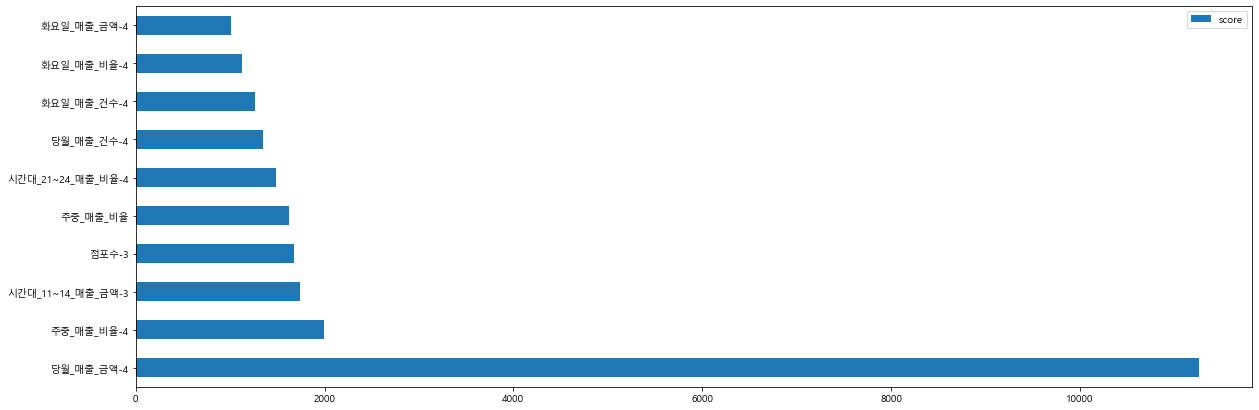

In [38]:
plt.rcParams['font.family'] = 'Malgun Gothic'
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh') #top 10개 선택해서 그리기

In [47]:
alpha = 0.7
linewidth = 2

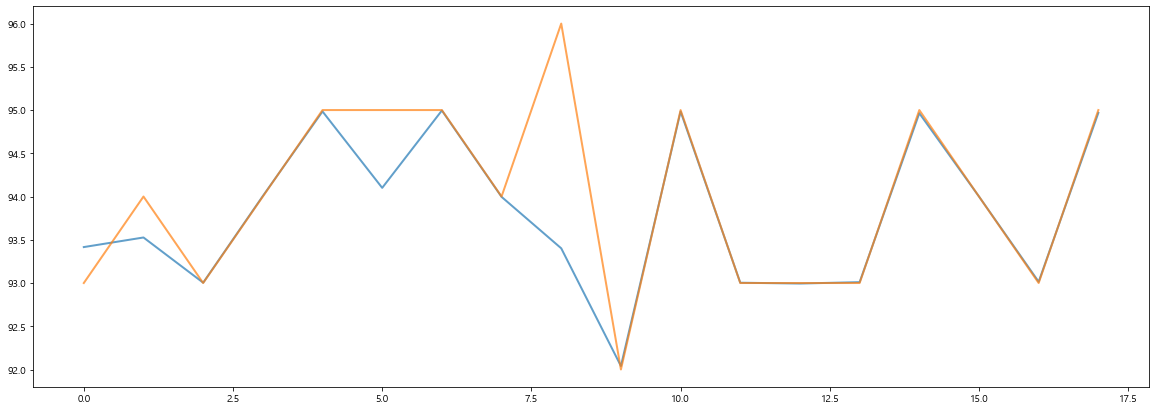

In [48]:
plt.pyplot.plot(model.predict(x_in),alpha = alpha,linewidth = linewidth)
# 파란색 : 예측값
# 주황색 : 실제값
# 갈색 : 파란색과 주황색이 겹치는 부분
plt.pyplot.plot(x_out.values,alpha = alpha,linewidth = linewidth)

### 생존율을 결정짓는 주요 요인 분석하기

In [40]:
total=100 #백분율
x_out['폐업_률']=total-x_out['폐업_률']
x_out

,폐업_률
0,93
1,94
2,93
3,94
4,95
5,95
6,95
7,94
8,96
9,92


In [41]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score
test_size=0.2
random_state=42
# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=test_size, random_state=random_state)

In [49]:
n_estimators=9000
learning_rate=0.001
max_depth=12
n_jobs=-1
subsample=0.75
reg_lambda=1
colsample_bytree=1
gamma=0

In [ ]:
# xgboost 학습
model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=n_estimators, learning_rate=learning_rate,
                      max_depth=max_depth,n_jobs= n_jobs,subsample=subsample,reg_lambda=reg_lambda,
                     colsample_bytree=colsample_bytree, gamma=gamma)

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_강남구_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:93.92175
[1]	validation_0-rmse:93.83674
[2]	validation_0-rmse:93.75075
[3]	validation_0-rmse:93.66562
[4]	validation_0-rmse:93.58130
[5]	validation_0-rmse:93.49813
[6]	validation_0-rmse:93.41238
[7]	validation_0-rmse:93.32857
[8]	validation_0-rmse:93.24290
[9]	validation_0-rmse:93.15797
[10]	validation_0-rmse:93.07449
[11]	validation_0-rmse:92.98913
[12]	validation_0-rmse:92.90377
[13]	validation_0-rmse:92.81924
[14]	validation_0-rmse:92.73463
[15]	validation_0-rmse:92.65098
[16]	validation_0-rmse:92.56563
[17]	validation_0-rmse:92.47985
[18]	validation_0-rmse:92.39844
[19]	validation_0-rmse:92.31816
[20]	validation_0-rmse:92.23656
[21]	validation_0-rmse:92.15502
[22]	validation_0-rmse:92.07014
[23]	validation_0-rmse:91.98814
[24]	validation_0-rmse:91.90453
[25]	validation_0-rmse:91.82164
[26]	validation_0-rmse:91.73946
[27]	validation_0-rmse:91.65497
[28]	validation_0-rmse:91.57054
[29]	validation_0-rmse:91.48900
[30]	validation_0-rmse:91.40835
[31]	validation_0-

[252]	validation_0-rmse:74.80686
[253]	validation_0-rmse:74.73885
[254]	validation_0-rmse:74.67137
[255]	validation_0-rmse:74.60443
[256]	validation_0-rmse:74.53542
[257]	validation_0-rmse:74.46840
[258]	validation_0-rmse:74.40289
[259]	validation_0-rmse:74.33649
[260]	validation_0-rmse:74.26802
[261]	validation_0-rmse:74.20258
[262]	validation_0-rmse:74.13558
[263]	validation_0-rmse:74.06737
[264]	validation_0-rmse:74.00011
[265]	validation_0-rmse:73.93236
[266]	validation_0-rmse:73.86589
[267]	validation_0-rmse:73.79921
[268]	validation_0-rmse:73.73171
[269]	validation_0-rmse:73.66778
[270]	validation_0-rmse:73.59992
[271]	validation_0-rmse:73.53310
[272]	validation_0-rmse:73.46570
[273]	validation_0-rmse:73.39908
[274]	validation_0-rmse:73.33147
[275]	validation_0-rmse:73.26464
[276]	validation_0-rmse:73.19851
[277]	validation_0-rmse:73.13281
[278]	validation_0-rmse:73.06558
[279]	validation_0-rmse:72.99933
[280]	validation_0-rmse:72.93353
[281]	validation_0-rmse:72.86715
[282]	vali

[501]	validation_0-rmse:59.75257
[502]	validation_0-rmse:59.69835
[503]	validation_0-rmse:59.64395
[504]	validation_0-rmse:59.58993
[505]	validation_0-rmse:59.53529
[506]	validation_0-rmse:59.48191
[507]	validation_0-rmse:59.42925
[508]	validation_0-rmse:59.37597
[509]	validation_0-rmse:59.32292
[510]	validation_0-rmse:59.26955
[511]	validation_0-rmse:59.21633
[512]	validation_0-rmse:59.16305
[513]	validation_0-rmse:59.10966
[514]	validation_0-rmse:59.05648
[515]	validation_0-rmse:59.00327
[516]	validation_0-rmse:58.94929
[517]	validation_0-rmse:58.89559
[518]	validation_0-rmse:58.84170
[519]	validation_0-rmse:58.78849
[520]	validation_0-rmse:58.73533
[521]	validation_0-rmse:58.68175
[522]	validation_0-rmse:58.62844
[523]	validation_0-rmse:58.57690
[524]	validation_0-rmse:58.52320
[525]	validation_0-rmse:58.47100
[526]	validation_0-rmse:58.41885
[527]	validation_0-rmse:58.36533
[528]	validation_0-rmse:58.31182
[529]	validation_0-rmse:58.25893
[530]	validation_0-rmse:58.20681
[531]	vali

[750]	validation_0-rmse:47.74527
[751]	validation_0-rmse:47.70224
[752]	validation_0-rmse:47.65907
[753]	validation_0-rmse:47.61833
[754]	validation_0-rmse:47.57541
[755]	validation_0-rmse:47.53199
[756]	validation_0-rmse:47.49008
[757]	validation_0-rmse:47.44748
[758]	validation_0-rmse:47.40391
[759]	validation_0-rmse:47.36152
[760]	validation_0-rmse:47.31867
[761]	validation_0-rmse:47.27594
[762]	validation_0-rmse:47.23275
[763]	validation_0-rmse:47.19056
[764]	validation_0-rmse:47.14859
[765]	validation_0-rmse:47.10593
[766]	validation_0-rmse:47.06286
[767]	validation_0-rmse:47.01998
[768]	validation_0-rmse:46.97899
[769]	validation_0-rmse:46.93618
[770]	validation_0-rmse:46.89417
[771]	validation_0-rmse:46.85160
[772]	validation_0-rmse:46.80947
[773]	validation_0-rmse:46.76704
[774]	validation_0-rmse:46.72683
[775]	validation_0-rmse:46.68510
[776]	validation_0-rmse:46.64406
[777]	validation_0-rmse:46.60157
[778]	validation_0-rmse:46.55969
[779]	validation_0-rmse:46.51701
[780]	vali

[999]	validation_0-rmse:38.17979
[1000]	validation_0-rmse:38.14584
[1001]	validation_0-rmse:38.11210
[1002]	validation_0-rmse:38.07735
[1003]	validation_0-rmse:38.04284
[1004]	validation_0-rmse:38.00874
[1005]	validation_0-rmse:37.97439
[1006]	validation_0-rmse:37.93976
[1007]	validation_0-rmse:37.90572
[1008]	validation_0-rmse:37.87184
[1009]	validation_0-rmse:37.83786
[1010]	validation_0-rmse:37.80392
[1011]	validation_0-rmse:37.76959
[1012]	validation_0-rmse:37.73571
[1013]	validation_0-rmse:37.70129
[1014]	validation_0-rmse:37.66786
[1015]	validation_0-rmse:37.63484
[1016]	validation_0-rmse:37.60035
[1017]	validation_0-rmse:37.56636
[1018]	validation_0-rmse:37.53278
[1019]	validation_0-rmse:37.49895
[1020]	validation_0-rmse:37.46654
[1021]	validation_0-rmse:37.43305
[1022]	validation_0-rmse:37.39893
[1023]	validation_0-rmse:37.36541
[1024]	validation_0-rmse:37.33172
[1025]	validation_0-rmse:37.30089
[1026]	validation_0-rmse:37.26790
[1027]	validation_0-rmse:37.23598
[1028]	validati

[1240]	validation_0-rmse:30.78555
[1241]	validation_0-rmse:30.75754
[1242]	validation_0-rmse:30.73017
[1243]	validation_0-rmse:30.70235
[1244]	validation_0-rmse:30.67521
[1245]	validation_0-rmse:30.64754
[1246]	validation_0-rmse:30.61973
[1247]	validation_0-rmse:30.59286
[1248]	validation_0-rmse:30.56547
[1249]	validation_0-rmse:30.53818
[1250]	validation_0-rmse:30.51118
[1251]	validation_0-rmse:30.48350
[1252]	validation_0-rmse:30.45586
[1253]	validation_0-rmse:30.42822
[1254]	validation_0-rmse:30.40142
[1255]	validation_0-rmse:30.37421
[1256]	validation_0-rmse:30.34824
[1257]	validation_0-rmse:30.32072
[1258]	validation_0-rmse:30.29442
[1259]	validation_0-rmse:30.26715
[1260]	validation_0-rmse:30.24007
[1261]	validation_0-rmse:30.21334
[1262]	validation_0-rmse:30.18703
[1263]	validation_0-rmse:30.16008
[1264]	validation_0-rmse:30.13404
[1265]	validation_0-rmse:30.10724
[1266]	validation_0-rmse:30.08187
[1267]	validation_0-rmse:30.05529
[1268]	validation_0-rmse:30.02848
[1269]	validat

[1481]	validation_0-rmse:24.86492
[1482]	validation_0-rmse:24.84272
[1483]	validation_0-rmse:24.82063
[1484]	validation_0-rmse:24.79857
[1485]	validation_0-rmse:24.77705
[1486]	validation_0-rmse:24.75548
[1487]	validation_0-rmse:24.73379
[1488]	validation_0-rmse:24.71203
[1489]	validation_0-rmse:24.69033
[1490]	validation_0-rmse:24.66884
[1491]	validation_0-rmse:24.64690
[1492]	validation_0-rmse:24.62460
[1493]	validation_0-rmse:24.60289
[1494]	validation_0-rmse:24.58077
[1495]	validation_0-rmse:24.55891
[1496]	validation_0-rmse:24.53717
[1497]	validation_0-rmse:24.51564
[1498]	validation_0-rmse:24.49375
[1499]	validation_0-rmse:24.47173
[1500]	validation_0-rmse:24.44972
[1501]	validation_0-rmse:24.42826
[1502]	validation_0-rmse:24.40637
[1503]	validation_0-rmse:24.38468
[1504]	validation_0-rmse:24.36310
[1505]	validation_0-rmse:24.34145
[1506]	validation_0-rmse:24.31957
[1507]	validation_0-rmse:24.29889
[1508]	validation_0-rmse:24.27739
[1509]	validation_0-rmse:24.25580
[1510]	validat

[1722]	validation_0-rmse:20.10083
[1723]	validation_0-rmse:20.08346
[1724]	validation_0-rmse:20.06559
[1725]	validation_0-rmse:20.04759
[1726]	validation_0-rmse:20.02981
[1727]	validation_0-rmse:20.01191
[1728]	validation_0-rmse:19.99442
[1729]	validation_0-rmse:19.97677
[1730]	validation_0-rmse:19.95906
[1731]	validation_0-rmse:19.94112
[1732]	validation_0-rmse:19.92323
[1733]	validation_0-rmse:19.90567
[1734]	validation_0-rmse:19.88817
[1735]	validation_0-rmse:19.87069
[1736]	validation_0-rmse:19.85316
[1737]	validation_0-rmse:19.83542
[1738]	validation_0-rmse:19.81799
[1739]	validation_0-rmse:19.80033
[1740]	validation_0-rmse:19.78268
[1741]	validation_0-rmse:19.76509
[1742]	validation_0-rmse:19.74781
[1743]	validation_0-rmse:19.73030
[1744]	validation_0-rmse:19.71335
[1745]	validation_0-rmse:19.69667
[1746]	validation_0-rmse:19.67929
[1747]	validation_0-rmse:19.66176
[1748]	validation_0-rmse:19.64421
[1749]	validation_0-rmse:19.62680
[1750]	validation_0-rmse:19.60947
[1751]	validat

[1963]	validation_0-rmse:16.27548
[1964]	validation_0-rmse:16.26151
[1965]	validation_0-rmse:16.24722
[1966]	validation_0-rmse:16.23331
[1967]	validation_0-rmse:16.21911
[1968]	validation_0-rmse:16.20494
[1969]	validation_0-rmse:16.19127
[1970]	validation_0-rmse:16.17725
[1971]	validation_0-rmse:16.16307
[1972]	validation_0-rmse:16.14911
[1973]	validation_0-rmse:16.13605
[1974]	validation_0-rmse:16.12182
[1975]	validation_0-rmse:16.10749
[1976]	validation_0-rmse:16.09359
[1977]	validation_0-rmse:16.07984
[1978]	validation_0-rmse:16.06628
[1979]	validation_0-rmse:16.05213
[1980]	validation_0-rmse:16.03825
[1981]	validation_0-rmse:16.02410
[1982]	validation_0-rmse:16.00997
[1983]	validation_0-rmse:15.99598
[1984]	validation_0-rmse:15.98183
[1985]	validation_0-rmse:15.96810
[1986]	validation_0-rmse:15.95404
[1987]	validation_0-rmse:15.94030
[1988]	validation_0-rmse:15.92661
[1989]	validation_0-rmse:15.91271
[1990]	validation_0-rmse:15.89911
[1991]	validation_0-rmse:15.88561
[1992]	validat

[2204]	validation_0-rmse:13.20894
[2205]	validation_0-rmse:13.19737
[2206]	validation_0-rmse:13.18573
[2207]	validation_0-rmse:13.17446
[2208]	validation_0-rmse:13.16327
[2209]	validation_0-rmse:13.15174
[2210]	validation_0-rmse:13.14016
[2211]	validation_0-rmse:13.12874
[2212]	validation_0-rmse:13.11717
[2213]	validation_0-rmse:13.10560
[2214]	validation_0-rmse:13.09423
[2215]	validation_0-rmse:13.08277
[2216]	validation_0-rmse:13.07174
[2217]	validation_0-rmse:13.06055
[2218]	validation_0-rmse:13.04946
[2219]	validation_0-rmse:13.03811
[2220]	validation_0-rmse:13.02670
[2221]	validation_0-rmse:13.01571
[2222]	validation_0-rmse:13.00463
[2223]	validation_0-rmse:12.99367
[2224]	validation_0-rmse:12.98258
[2225]	validation_0-rmse:12.97153
[2226]	validation_0-rmse:12.96089
[2227]	validation_0-rmse:12.94971
[2228]	validation_0-rmse:12.93848
[2229]	validation_0-rmse:12.92716
[2230]	validation_0-rmse:12.91646
[2231]	validation_0-rmse:12.90532
[2232]	validation_0-rmse:12.89403
[2233]	validat

[2445]	validation_0-rmse:10.74955
[2446]	validation_0-rmse:10.74105
[2447]	validation_0-rmse:10.73269
[2448]	validation_0-rmse:10.72335
[2449]	validation_0-rmse:10.71432
[2450]	validation_0-rmse:10.70492
[2451]	validation_0-rmse:10.69557
[2452]	validation_0-rmse:10.68667
[2453]	validation_0-rmse:10.67805
[2454]	validation_0-rmse:10.66874
[2455]	validation_0-rmse:10.65979
[2456]	validation_0-rmse:10.65068
[2457]	validation_0-rmse:10.64204
[2458]	validation_0-rmse:10.63311
[2459]	validation_0-rmse:10.62393
[2460]	validation_0-rmse:10.61485
[2461]	validation_0-rmse:10.60578
[2462]	validation_0-rmse:10.59708
[2463]	validation_0-rmse:10.58818
[2464]	validation_0-rmse:10.57906
[2465]	validation_0-rmse:10.57034
[2466]	validation_0-rmse:10.56155
[2467]	validation_0-rmse:10.55244
[2468]	validation_0-rmse:10.54358
[2469]	validation_0-rmse:10.53487
[2470]	validation_0-rmse:10.52585
[2471]	validation_0-rmse:10.51721
[2472]	validation_0-rmse:10.50838
[2473]	validation_0-rmse:10.49948
[2474]	validat

[2691]	validation_0-rmse:8.74418
[2692]	validation_0-rmse:8.73692
[2693]	validation_0-rmse:8.72974
[2694]	validation_0-rmse:8.72249
[2695]	validation_0-rmse:8.71575
[2696]	validation_0-rmse:8.70838
[2697]	validation_0-rmse:8.70131
[2698]	validation_0-rmse:8.69425
[2699]	validation_0-rmse:8.68760
[2700]	validation_0-rmse:8.68017
[2701]	validation_0-rmse:8.67288
[2702]	validation_0-rmse:8.66558
[2703]	validation_0-rmse:8.65838
[2704]	validation_0-rmse:8.65149
[2705]	validation_0-rmse:8.64457
[2706]	validation_0-rmse:8.63729
[2707]	validation_0-rmse:8.63029
[2708]	validation_0-rmse:8.62313
[2709]	validation_0-rmse:8.61569
[2710]	validation_0-rmse:8.60891
[2711]	validation_0-rmse:8.60174
[2712]	validation_0-rmse:8.59455
[2713]	validation_0-rmse:8.58771
[2714]	validation_0-rmse:8.58066
[2715]	validation_0-rmse:8.57372
[2716]	validation_0-rmse:8.56663
[2717]	validation_0-rmse:8.55933
[2718]	validation_0-rmse:8.55241
[2719]	validation_0-rmse:8.54586
[2720]	validation_0-rmse:8.53869
[2721]	val

[2940]	validation_0-rmse:7.13230
[2941]	validation_0-rmse:7.12698
[2942]	validation_0-rmse:7.12122
[2943]	validation_0-rmse:7.11589
[2944]	validation_0-rmse:7.11007
[2945]	validation_0-rmse:7.10439
[2946]	validation_0-rmse:7.09855
[2947]	validation_0-rmse:7.09274
[2948]	validation_0-rmse:7.08693
[2949]	validation_0-rmse:7.08154
[2950]	validation_0-rmse:7.07571
[2951]	validation_0-rmse:7.06992
[2952]	validation_0-rmse:7.06416
[2953]	validation_0-rmse:7.05839
[2954]	validation_0-rmse:7.05258
[2955]	validation_0-rmse:7.04654
[2956]	validation_0-rmse:7.04096
[2957]	validation_0-rmse:7.03511
[2958]	validation_0-rmse:7.02929
[2959]	validation_0-rmse:7.02365
[2960]	validation_0-rmse:7.01822
[2961]	validation_0-rmse:7.01291
[2962]	validation_0-rmse:7.00713
[2963]	validation_0-rmse:7.00140
[2964]	validation_0-rmse:6.99564
[2965]	validation_0-rmse:6.98987
[2966]	validation_0-rmse:6.98438
[2967]	validation_0-rmse:6.97880
[2968]	validation_0-rmse:6.97298
[2969]	validation_0-rmse:6.96770
[2970]	val

[3189]	validation_0-rmse:5.84922
[3190]	validation_0-rmse:5.84454
[3191]	validation_0-rmse:5.83980
[3192]	validation_0-rmse:5.83542
[3193]	validation_0-rmse:5.83076
[3194]	validation_0-rmse:5.82614
[3195]	validation_0-rmse:5.82157
[3196]	validation_0-rmse:5.81683
[3197]	validation_0-rmse:5.81227
[3198]	validation_0-rmse:5.80785
[3199]	validation_0-rmse:5.80356
[3200]	validation_0-rmse:5.79897
[3201]	validation_0-rmse:5.79439
[3202]	validation_0-rmse:5.78999
[3203]	validation_0-rmse:5.78546
[3204]	validation_0-rmse:5.78085
[3205]	validation_0-rmse:5.77660
[3206]	validation_0-rmse:5.77212
[3207]	validation_0-rmse:5.76778
[3208]	validation_0-rmse:5.76326
[3209]	validation_0-rmse:5.75880
[3210]	validation_0-rmse:5.75474
[3211]	validation_0-rmse:5.75023
[3212]	validation_0-rmse:5.74565
[3213]	validation_0-rmse:5.74112
[3214]	validation_0-rmse:5.73708
[3215]	validation_0-rmse:5.73255
[3216]	validation_0-rmse:5.72816
[3217]	validation_0-rmse:5.72413
[3218]	validation_0-rmse:5.71970
[3219]	val

[3438]	validation_0-rmse:4.84432
[3439]	validation_0-rmse:4.84073
[3440]	validation_0-rmse:4.83743
[3441]	validation_0-rmse:4.83398
[3442]	validation_0-rmse:4.83043
[3443]	validation_0-rmse:4.82682
[3444]	validation_0-rmse:4.82373
[3445]	validation_0-rmse:4.82015
[3446]	validation_0-rmse:4.81655
[3447]	validation_0-rmse:4.81294
[3448]	validation_0-rmse:4.81001
[3449]	validation_0-rmse:4.80724
[3450]	validation_0-rmse:4.80437
[3451]	validation_0-rmse:4.80085
[3452]	validation_0-rmse:4.79814
[3453]	validation_0-rmse:4.79516
[3454]	validation_0-rmse:4.79166
[3455]	validation_0-rmse:4.78829
[3456]	validation_0-rmse:4.78447
[3457]	validation_0-rmse:4.78094
[3458]	validation_0-rmse:4.77819
[3459]	validation_0-rmse:4.77471
[3460]	validation_0-rmse:4.77100
[3461]	validation_0-rmse:4.76786
[3462]	validation_0-rmse:4.76502
[3463]	validation_0-rmse:4.76150
[3464]	validation_0-rmse:4.75773
[3465]	validation_0-rmse:4.75418
[3466]	validation_0-rmse:4.75068
[3467]	validation_0-rmse:4.74695
[3468]	val

[3687]	validation_0-rmse:4.09920
[3688]	validation_0-rmse:4.09624
[3689]	validation_0-rmse:4.09317
[3690]	validation_0-rmse:4.09021
[3691]	validation_0-rmse:4.08757
[3692]	validation_0-rmse:4.08528
[3693]	validation_0-rmse:4.08306
[3694]	validation_0-rmse:4.07985
[3695]	validation_0-rmse:4.07720
[3696]	validation_0-rmse:4.07514
[3697]	validation_0-rmse:4.07233
[3698]	validation_0-rmse:4.06927
[3699]	validation_0-rmse:4.06679
[3700]	validation_0-rmse:4.06385
[3701]	validation_0-rmse:4.06104
[3702]	validation_0-rmse:4.05889
[3703]	validation_0-rmse:4.05602
[3704]	validation_0-rmse:4.05313
[3705]	validation_0-rmse:4.05058
[3706]	validation_0-rmse:4.04784
[3707]	validation_0-rmse:4.04490
[3708]	validation_0-rmse:4.04287
[3709]	validation_0-rmse:4.04116
[3710]	validation_0-rmse:4.03816
[3711]	validation_0-rmse:4.03519
[3712]	validation_0-rmse:4.03307
[3713]	validation_0-rmse:4.03042
[3714]	validation_0-rmse:4.02828
[3715]	validation_0-rmse:4.02610
[3716]	validation_0-rmse:4.02403
[3717]	val

[3936]	validation_0-rmse:3.50429
[3937]	validation_0-rmse:3.50202
[3938]	validation_0-rmse:3.49973
[3939]	validation_0-rmse:3.49771
[3940]	validation_0-rmse:3.49652
[3941]	validation_0-rmse:3.49429
[3942]	validation_0-rmse:3.49259
[3943]	validation_0-rmse:3.49039
[3944]	validation_0-rmse:3.48839
[3945]	validation_0-rmse:3.48617
[3946]	validation_0-rmse:3.48440
[3947]	validation_0-rmse:3.48214
[3948]	validation_0-rmse:3.48012
[3949]	validation_0-rmse:3.47792
[3950]	validation_0-rmse:3.47556
[3951]	validation_0-rmse:3.47322
[3952]	validation_0-rmse:3.47092
[3953]	validation_0-rmse:3.46871
[3954]	validation_0-rmse:3.46649
[3955]	validation_0-rmse:3.46420
[3956]	validation_0-rmse:3.46238
[3957]	validation_0-rmse:3.46037
[3958]	validation_0-rmse:3.45792
[3959]	validation_0-rmse:3.45604
[3960]	validation_0-rmse:3.45390
[3961]	validation_0-rmse:3.45178
[3962]	validation_0-rmse:3.44974
[3963]	validation_0-rmse:3.44736
[3964]	validation_0-rmse:3.44556
[3965]	validation_0-rmse:3.44329
[3966]	val

[4185]	validation_0-rmse:3.03976
[4186]	validation_0-rmse:3.03793
[4187]	validation_0-rmse:3.03614
[4188]	validation_0-rmse:3.03448
[4189]	validation_0-rmse:3.03330
[4190]	validation_0-rmse:3.03162
[4191]	validation_0-rmse:3.03021
[4192]	validation_0-rmse:3.02897
[4193]	validation_0-rmse:3.02726
[4194]	validation_0-rmse:3.02551
[4195]	validation_0-rmse:3.02419
[4196]	validation_0-rmse:3.02244
[4197]	validation_0-rmse:3.02095
[4198]	validation_0-rmse:3.01926
[4199]	validation_0-rmse:3.01798
[4200]	validation_0-rmse:3.01621
[4201]	validation_0-rmse:3.01473
[4202]	validation_0-rmse:3.01371
[4203]	validation_0-rmse:3.01225
[4204]	validation_0-rmse:3.01105
[4205]	validation_0-rmse:3.00972
[4206]	validation_0-rmse:3.00831
[4207]	validation_0-rmse:3.00630
[4208]	validation_0-rmse:3.00460
[4209]	validation_0-rmse:3.00268
[4210]	validation_0-rmse:3.00097
[4211]	validation_0-rmse:2.99918
[4212]	validation_0-rmse:2.99764
[4213]	validation_0-rmse:2.99633
[4214]	validation_0-rmse:2.99470
[4215]	val

[4434]	validation_0-rmse:2.68413
[4435]	validation_0-rmse:2.68264
[4436]	validation_0-rmse:2.68146
[4437]	validation_0-rmse:2.68022
[4438]	validation_0-rmse:2.67855
[4439]	validation_0-rmse:2.67749
[4440]	validation_0-rmse:2.67691
[4441]	validation_0-rmse:2.67552
[4442]	validation_0-rmse:2.67450
[4443]	validation_0-rmse:2.67374
[4444]	validation_0-rmse:2.67196
[4445]	validation_0-rmse:2.67102
[4446]	validation_0-rmse:2.66972
[4447]	validation_0-rmse:2.66856
[4448]	validation_0-rmse:2.66733
[4449]	validation_0-rmse:2.66627
[4450]	validation_0-rmse:2.66488
[4451]	validation_0-rmse:2.66309
[4452]	validation_0-rmse:2.66196
[4453]	validation_0-rmse:2.66133
[4454]	validation_0-rmse:2.66002
[4455]	validation_0-rmse:2.65900
[4456]	validation_0-rmse:2.65773
[4457]	validation_0-rmse:2.65676
[4458]	validation_0-rmse:2.65607
[4459]	validation_0-rmse:2.65461
[4460]	validation_0-rmse:2.65375
[4461]	validation_0-rmse:2.65240
[4462]	validation_0-rmse:2.65166
[4463]	validation_0-rmse:2.65037
[4464]	val

[4683]	validation_0-rmse:2.40273
[4684]	validation_0-rmse:2.40186
[4685]	validation_0-rmse:2.40127
[4686]	validation_0-rmse:2.40027
[4687]	validation_0-rmse:2.39955
[4688]	validation_0-rmse:2.39839
[4689]	validation_0-rmse:2.39748
[4690]	validation_0-rmse:2.39645
[4691]	validation_0-rmse:2.39533
[4692]	validation_0-rmse:2.39437
[4693]	validation_0-rmse:2.39328
[4694]	validation_0-rmse:2.39207
[4695]	validation_0-rmse:2.39108
[4696]	validation_0-rmse:2.39040
[4697]	validation_0-rmse:2.38993
[4698]	validation_0-rmse:2.38880
[4699]	validation_0-rmse:2.38797
[4700]	validation_0-rmse:2.38652
[4701]	validation_0-rmse:2.38543
[4702]	validation_0-rmse:2.38447
[4703]	validation_0-rmse:2.38352
[4704]	validation_0-rmse:2.38237
[4705]	validation_0-rmse:2.38124
[4706]	validation_0-rmse:2.38024
[4707]	validation_0-rmse:2.37953
[4708]	validation_0-rmse:2.37854
[4709]	validation_0-rmse:2.37765
[4710]	validation_0-rmse:2.37718
[4711]	validation_0-rmse:2.37608
[4712]	validation_0-rmse:2.37493
[4713]	val

[4932]	validation_0-rmse:2.19013
[4933]	validation_0-rmse:2.18942
[4934]	validation_0-rmse:2.18854
[4935]	validation_0-rmse:2.18750
[4936]	validation_0-rmse:2.18695
[4937]	validation_0-rmse:2.18606
[4938]	validation_0-rmse:2.18555
[4939]	validation_0-rmse:2.18495
[4940]	validation_0-rmse:2.18462
[4941]	validation_0-rmse:2.18343
[4942]	validation_0-rmse:2.18296
[4943]	validation_0-rmse:2.18216
[4944]	validation_0-rmse:2.18135
[4945]	validation_0-rmse:2.18104
[4946]	validation_0-rmse:2.18039
[4947]	validation_0-rmse:2.17935
[4948]	validation_0-rmse:2.17901
[4949]	validation_0-rmse:2.17830
[4950]	validation_0-rmse:2.17774
[4951]	validation_0-rmse:2.17643
[4952]	validation_0-rmse:2.17557
[4953]	validation_0-rmse:2.17524
[4954]	validation_0-rmse:2.17394
[4955]	validation_0-rmse:2.17347
[4956]	validation_0-rmse:2.17274
[4957]	validation_0-rmse:2.17231
[4958]	validation_0-rmse:2.17140
[4959]	validation_0-rmse:2.17066
[4960]	validation_0-rmse:2.17027
[4961]	validation_0-rmse:2.16962
[4962]	val

[5181]	validation_0-rmse:2.02009
[5182]	validation_0-rmse:2.01943
[5183]	validation_0-rmse:2.01896
[5184]	validation_0-rmse:2.01837
[5185]	validation_0-rmse:2.01751
[5186]	validation_0-rmse:2.01703
[5187]	validation_0-rmse:2.01640
[5188]	validation_0-rmse:2.01551
[5189]	validation_0-rmse:2.01490
[5190]	validation_0-rmse:2.01431
[5191]	validation_0-rmse:2.01367
[5192]	validation_0-rmse:2.01303
[5193]	validation_0-rmse:2.01282
[5194]	validation_0-rmse:2.01257
[5195]	validation_0-rmse:2.01220
[5196]	validation_0-rmse:2.01161
[5197]	validation_0-rmse:2.01103
[5198]	validation_0-rmse:2.01051
[5199]	validation_0-rmse:2.01004
[5200]	validation_0-rmse:2.00952
[5201]	validation_0-rmse:2.00857
[5202]	validation_0-rmse:2.00794
[5203]	validation_0-rmse:2.00732
[5204]	validation_0-rmse:2.00679
[5205]	validation_0-rmse:2.00636
[5206]	validation_0-rmse:2.00547
[5207]	validation_0-rmse:2.00487
[5208]	validation_0-rmse:2.00398
[5209]	validation_0-rmse:2.00330
[5210]	validation_0-rmse:2.00260
[5211]	val

[5430]	validation_0-rmse:1.88761
[5431]	validation_0-rmse:1.88715
[5432]	validation_0-rmse:1.88683
[5433]	validation_0-rmse:1.88608
[5434]	validation_0-rmse:1.88558
[5435]	validation_0-rmse:1.88530
[5436]	validation_0-rmse:1.88499
[5437]	validation_0-rmse:1.88441
[5438]	validation_0-rmse:1.88377
[5439]	validation_0-rmse:1.88357
[5440]	validation_0-rmse:1.88292
[5441]	validation_0-rmse:1.88261
[5442]	validation_0-rmse:1.88240
[5443]	validation_0-rmse:1.88205
[5444]	validation_0-rmse:1.88173
[5445]	validation_0-rmse:1.88115
[5446]	validation_0-rmse:1.88041
[5447]	validation_0-rmse:1.88012
[5448]	validation_0-rmse:1.87927
[5449]	validation_0-rmse:1.87896
[5450]	validation_0-rmse:1.87860
[5451]	validation_0-rmse:1.87838
[5452]	validation_0-rmse:1.87778
[5453]	validation_0-rmse:1.87723
[5454]	validation_0-rmse:1.87691
[5455]	validation_0-rmse:1.87630
[5456]	validation_0-rmse:1.87581
[5457]	validation_0-rmse:1.87552
[5458]	validation_0-rmse:1.87505
[5459]	validation_0-rmse:1.87479
[5460]	val

[5679]	validation_0-rmse:1.78158
[5680]	validation_0-rmse:1.78137
[5681]	validation_0-rmse:1.78104
[5682]	validation_0-rmse:1.78047
[5683]	validation_0-rmse:1.78001
[5684]	validation_0-rmse:1.77968
[5685]	validation_0-rmse:1.77944
[5686]	validation_0-rmse:1.77912
[5687]	validation_0-rmse:1.77852
[5688]	validation_0-rmse:1.77823
[5689]	validation_0-rmse:1.77772
[5690]	validation_0-rmse:1.77739
[5691]	validation_0-rmse:1.77683
[5692]	validation_0-rmse:1.77611
[5693]	validation_0-rmse:1.77574
[5694]	validation_0-rmse:1.77533
[5695]	validation_0-rmse:1.77511
[5696]	validation_0-rmse:1.77487
[5697]	validation_0-rmse:1.77439
[5698]	validation_0-rmse:1.77417
[5699]	validation_0-rmse:1.77397
[5700]	validation_0-rmse:1.77330
[5701]	validation_0-rmse:1.77309
[5702]	validation_0-rmse:1.77282
[5703]	validation_0-rmse:1.77259
[5704]	validation_0-rmse:1.77213
[5705]	validation_0-rmse:1.77159
[5706]	validation_0-rmse:1.77114
[5707]	validation_0-rmse:1.77041
[5708]	validation_0-rmse:1.77013
[5709]	val

[5928]	validation_0-rmse:1.70248
[5929]	validation_0-rmse:1.70209
[5930]	validation_0-rmse:1.70189
[5931]	validation_0-rmse:1.70178
[5932]	validation_0-rmse:1.70173
[5933]	validation_0-rmse:1.70109
[5934]	validation_0-rmse:1.70053
[5935]	validation_0-rmse:1.70012
[5936]	validation_0-rmse:1.69955
[5937]	validation_0-rmse:1.69923
[5938]	validation_0-rmse:1.69872
[5939]	validation_0-rmse:1.69828
[5940]	validation_0-rmse:1.69808
[5941]	validation_0-rmse:1.69780
[5942]	validation_0-rmse:1.69720
[5943]	validation_0-rmse:1.69708
[5944]	validation_0-rmse:1.69661
[5945]	validation_0-rmse:1.69650
[5946]	validation_0-rmse:1.69633
[5947]	validation_0-rmse:1.69616
[5948]	validation_0-rmse:1.69603
[5949]	validation_0-rmse:1.69573
[5950]	validation_0-rmse:1.69548
[5951]	validation_0-rmse:1.69536
[5952]	validation_0-rmse:1.69495
[5953]	validation_0-rmse:1.69464
[5954]	validation_0-rmse:1.69443
[5955]	validation_0-rmse:1.69413
[5956]	validation_0-rmse:1.69387
[5957]	validation_0-rmse:1.69362
[5958]	val

[6177]	validation_0-rmse:1.64041
[6178]	validation_0-rmse:1.63995
[6179]	validation_0-rmse:1.63975
[6180]	validation_0-rmse:1.63941
[6181]	validation_0-rmse:1.63898
[6182]	validation_0-rmse:1.63867
[6183]	validation_0-rmse:1.63840
[6184]	validation_0-rmse:1.63799
[6185]	validation_0-rmse:1.63753
[6186]	validation_0-rmse:1.63738
[6187]	validation_0-rmse:1.63727
[6188]	validation_0-rmse:1.63681
[6189]	validation_0-rmse:1.63635
[6190]	validation_0-rmse:1.63592
[6191]	validation_0-rmse:1.63578
[6192]	validation_0-rmse:1.63558
[6193]	validation_0-rmse:1.63512
[6194]	validation_0-rmse:1.63462
[6195]	validation_0-rmse:1.63442
[6196]	validation_0-rmse:1.63391
[6197]	validation_0-rmse:1.63380
[6198]	validation_0-rmse:1.63356
[6199]	validation_0-rmse:1.63306
[6200]	validation_0-rmse:1.63296
[6201]	validation_0-rmse:1.63261
[6202]	validation_0-rmse:1.63245
[6203]	validation_0-rmse:1.63216
[6204]	validation_0-rmse:1.63206
[6205]	validation_0-rmse:1.63157
[6206]	validation_0-rmse:1.63137
[6207]	val

[6426]	validation_0-rmse:1.58559
[6427]	validation_0-rmse:1.58543
[6428]	validation_0-rmse:1.58513
[6429]	validation_0-rmse:1.58498
[6430]	validation_0-rmse:1.58459
[6431]	validation_0-rmse:1.58444
[6432]	validation_0-rmse:1.58407
[6433]	validation_0-rmse:1.58395
[6434]	validation_0-rmse:1.58382
[6435]	validation_0-rmse:1.58365
[6436]	validation_0-rmse:1.58350
[6437]	validation_0-rmse:1.58329
[6438]	validation_0-rmse:1.58291
[6439]	validation_0-rmse:1.58287
[6440]	validation_0-rmse:1.58274
[6441]	validation_0-rmse:1.58255
[6442]	validation_0-rmse:1.58217
[6443]	validation_0-rmse:1.58213
[6444]	validation_0-rmse:1.58183
[6445]	validation_0-rmse:1.58152
[6446]	validation_0-rmse:1.58125
[6447]	validation_0-rmse:1.58112
[6448]	validation_0-rmse:1.58091
[6449]	validation_0-rmse:1.58087
[6450]	validation_0-rmse:1.58082
[6451]	validation_0-rmse:1.58067
[6452]	validation_0-rmse:1.58052
[6453]	validation_0-rmse:1.58047
[6454]	validation_0-rmse:1.58031
[6455]	validation_0-rmse:1.58024
[6456]	val

[6675]	validation_0-rmse:1.54802
[6676]	validation_0-rmse:1.54792
[6677]	validation_0-rmse:1.54786
[6678]	validation_0-rmse:1.54782
[6679]	validation_0-rmse:1.54750
[6680]	validation_0-rmse:1.54711
[6681]	validation_0-rmse:1.54699
[6682]	validation_0-rmse:1.54677
[6683]	validation_0-rmse:1.54675
[6684]	validation_0-rmse:1.54644
[6685]	validation_0-rmse:1.54635
[6686]	validation_0-rmse:1.54626
[6687]	validation_0-rmse:1.54604
[6688]	validation_0-rmse:1.54596
[6689]	validation_0-rmse:1.54588
[6690]	validation_0-rmse:1.54565
[6691]	validation_0-rmse:1.54555
[6692]	validation_0-rmse:1.54533
[6693]	validation_0-rmse:1.54524
[6694]	validation_0-rmse:1.54517
[6695]	validation_0-rmse:1.54503
[6696]	validation_0-rmse:1.54480
[6697]	validation_0-rmse:1.54475
[6698]	validation_0-rmse:1.54468
[6699]	validation_0-rmse:1.54470
[6700]	validation_0-rmse:1.54455
[6701]	validation_0-rmse:1.54443
[6702]	validation_0-rmse:1.54433
[6703]	validation_0-rmse:1.54403
[6704]	validation_0-rmse:1.54399
[6705]	val

[6924]	validation_0-rmse:1.51879
[6925]	validation_0-rmse:1.51880
[6926]	validation_0-rmse:1.51852
[6927]	validation_0-rmse:1.51844
[6928]	validation_0-rmse:1.51841
[6929]	validation_0-rmse:1.51831
[6930]	validation_0-rmse:1.51831
[6931]	validation_0-rmse:1.51830
[6932]	validation_0-rmse:1.51807
[6933]	validation_0-rmse:1.51780
[6934]	validation_0-rmse:1.51779
[6935]	validation_0-rmse:1.51751
[6936]	validation_0-rmse:1.51747
[6937]	validation_0-rmse:1.51722
[6938]	validation_0-rmse:1.51715
[6939]	validation_0-rmse:1.51712
[6940]	validation_0-rmse:1.51699
[6941]	validation_0-rmse:1.51689
[6942]	validation_0-rmse:1.51683
[6943]	validation_0-rmse:1.51682
[6944]	validation_0-rmse:1.51650
[6945]	validation_0-rmse:1.51641
[6946]	validation_0-rmse:1.51612
[6947]	validation_0-rmse:1.51590
[6948]	validation_0-rmse:1.51568
[6949]	validation_0-rmse:1.51555
[6950]	validation_0-rmse:1.51551
[6951]	validation_0-rmse:1.51550
[6952]	validation_0-rmse:1.51552
[6953]	validation_0-rmse:1.51549
[6954]	val

[7173]	validation_0-rmse:1.49607
[7174]	validation_0-rmse:1.49583
[7175]	validation_0-rmse:1.49581
[7176]	validation_0-rmse:1.49564
[7177]	validation_0-rmse:1.49548
[7178]	validation_0-rmse:1.49549
[7179]	validation_0-rmse:1.49533
[7180]	validation_0-rmse:1.49526
[7181]	validation_0-rmse:1.49526
[7182]	validation_0-rmse:1.49499
[7183]	validation_0-rmse:1.49477
[7184]	validation_0-rmse:1.49465
[7185]	validation_0-rmse:1.49460
[7186]	validation_0-rmse:1.49459
[7187]	validation_0-rmse:1.49443
[7188]	validation_0-rmse:1.49444
[7189]	validation_0-rmse:1.49425
[7190]	validation_0-rmse:1.49421
[7191]	validation_0-rmse:1.49399
[7192]	validation_0-rmse:1.49399
[7193]	validation_0-rmse:1.49388
[7194]	validation_0-rmse:1.49385
[7195]	validation_0-rmse:1.49382
[7196]	validation_0-rmse:1.49375
[7197]	validation_0-rmse:1.49372
[7198]	validation_0-rmse:1.49364
[7199]	validation_0-rmse:1.49350
[7200]	validation_0-rmse:1.49343
[7201]	validation_0-rmse:1.49341
[7202]	validation_0-rmse:1.49335
[7203]	val

[7422]	validation_0-rmse:1.47793
[7423]	validation_0-rmse:1.47789
[7424]	validation_0-rmse:1.47777
[7425]	validation_0-rmse:1.47775
[7426]	validation_0-rmse:1.47773
[7427]	validation_0-rmse:1.47760
[7428]	validation_0-rmse:1.47756
[7429]	validation_0-rmse:1.47752
[7430]	validation_0-rmse:1.47746
[7431]	validation_0-rmse:1.47727
[7432]	validation_0-rmse:1.47720
[7433]	validation_0-rmse:1.47715
[7434]	validation_0-rmse:1.47706
[7435]	validation_0-rmse:1.47697
[7436]	validation_0-rmse:1.47688
[7437]	validation_0-rmse:1.47689
[7438]	validation_0-rmse:1.47670
[7439]	validation_0-rmse:1.47649
[7440]	validation_0-rmse:1.47649
[7441]	validation_0-rmse:1.47644
[7442]	validation_0-rmse:1.47648
[7443]	validation_0-rmse:1.47646
[7444]	validation_0-rmse:1.47645
[7445]	validation_0-rmse:1.47639
[7446]	validation_0-rmse:1.47642
[7447]	validation_0-rmse:1.47633
[7448]	validation_0-rmse:1.47632
[7449]	validation_0-rmse:1.47632
[7450]	validation_0-rmse:1.47629
[7451]	validation_0-rmse:1.47619
[7452]	val

[7671]	validation_0-rmse:1.46224
[7672]	validation_0-rmse:1.46225
[7673]	validation_0-rmse:1.46226
[7674]	validation_0-rmse:1.46219
[7675]	validation_0-rmse:1.46221
[7676]	validation_0-rmse:1.46209
[7677]	validation_0-rmse:1.46192
[7678]	validation_0-rmse:1.46190
[7679]	validation_0-rmse:1.46173
[7680]	validation_0-rmse:1.46168
[7681]	validation_0-rmse:1.46157
[7682]	validation_0-rmse:1.46143
[7683]	validation_0-rmse:1.46143
[7684]	validation_0-rmse:1.46143
[7685]	validation_0-rmse:1.46127
[7686]	validation_0-rmse:1.46123
[7687]	validation_0-rmse:1.46116
[7688]	validation_0-rmse:1.46118
[7689]	validation_0-rmse:1.46099
[7690]	validation_0-rmse:1.46098
[7691]	validation_0-rmse:1.46094
[7692]	validation_0-rmse:1.46083
[7693]	validation_0-rmse:1.46080
[7694]	validation_0-rmse:1.46078
[7695]	validation_0-rmse:1.46073
[7696]	validation_0-rmse:1.46076
[7697]	validation_0-rmse:1.46077
[7698]	validation_0-rmse:1.46059
[7699]	validation_0-rmse:1.46043
[7700]	validation_0-rmse:1.46039
[7701]	val

[7920]	validation_0-rmse:1.44995
[7921]	validation_0-rmse:1.44987
[7922]	validation_0-rmse:1.44985
[7923]	validation_0-rmse:1.44983
[7924]	validation_0-rmse:1.44983
[7925]	validation_0-rmse:1.44986
[7926]	validation_0-rmse:1.44988
[7927]	validation_0-rmse:1.44975
[7928]	validation_0-rmse:1.44971
[7929]	validation_0-rmse:1.44974
[7930]	validation_0-rmse:1.44975
[7931]	validation_0-rmse:1.44974
[7932]	validation_0-rmse:1.44973
[7933]	validation_0-rmse:1.44956
[7934]	validation_0-rmse:1.44941
[7935]	validation_0-rmse:1.44943
[7936]	validation_0-rmse:1.44939
[7937]	validation_0-rmse:1.44924
[7938]	validation_0-rmse:1.44920
[7939]	validation_0-rmse:1.44923
[7940]	validation_0-rmse:1.44911
[7941]	validation_0-rmse:1.44896
[7942]	validation_0-rmse:1.44882
[7943]	validation_0-rmse:1.44882
[7944]	validation_0-rmse:1.44878
[7945]	validation_0-rmse:1.44866
[7946]	validation_0-rmse:1.44853
[7947]	validation_0-rmse:1.44854
[7948]	validation_0-rmse:1.44858
[7949]	validation_0-rmse:1.44847
[7950]	val

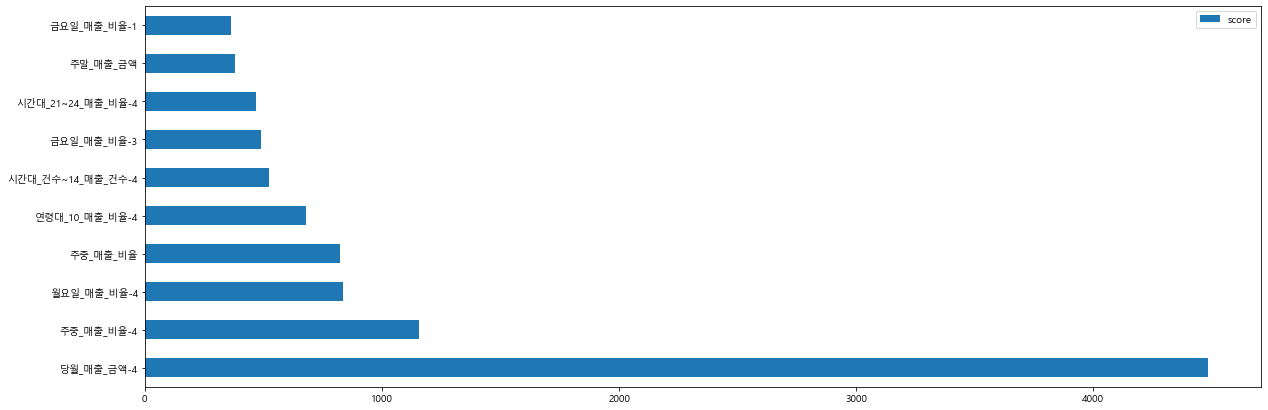

In [43]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh') #top 10개 선택해서 그리기